<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW2/04_04_simple_GAN_7_kyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **실습 4-4 : 간단한 GAN 모델 만들기** 

## **Import Module**

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import models,layers 

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

plt.style.use("seaborn-dark")

In [0]:
# gdriver mount to load saved model
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## **DataSet**

### 라벨있는 샘플 데이터 생성

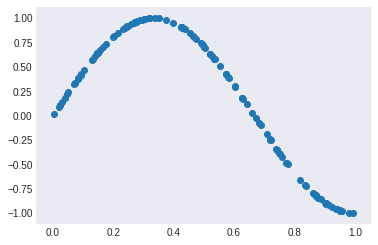

In [0]:
# Generate n개의 Real Samples with Class Labels
def generate_real_samples(n):
	# generate inputs in [0,1]
	X1 = np.random.rand(n)	# x축
	# generate outputs sin(1.5*pi*x1) : 0~270
	X2 = np.sin(X1*np.pi*1.5) # y축
	# stack arrays
	X1 = X1.reshape(n, 1)		#(n,1)<-(n)
	X2 = X2.reshape(n, 1)		#(n개의 1차원 vector)<-(n차원 vector) 
	X = np.hstack((X1, X2))	#(n,2)<-(n,1)(n,1)
	# generate class labels
	y = np.ones((n, 1))	#True 
	return X, y 				# shape=((n,2),1)

# Generate Real Data Samples
data = generate_real_samples(128)

# Plot Real Samples
plt.scatter(data[0][:, 0], data[0][:, 1])
plt.show() #순서가 random인 sin 

## **GAN 모델링**

### 판별기 (discriminator)

In [0]:
# Define the standalone Discriminator Model
def define_discriminator(n_inputs=2): # target이 없음
	model = models.Sequential(name="Discriminator")
	model.add(layers.Dense(25, activation='relu', 
	            kernel_initializer='he_uniform', input_dim=n_inputs))	# Param # == 25(output) * 2(input) + 25(output)
	model.add(layers.Dense(1, activation='sigmoid'))	# 내가 target으로 하는 값과 비교를 해주기 위해서!
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

d_model=define_discriminator()

d_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### 생성기 (generator)


In [0]:
# Define the standalone Generator Model
def define_generator(latent_dim, n_outputs=2):	# latent_dim은 5-dim vector 하나만 들어올 것! ( 이 셀의 밑에서 두 번째 줄 봐라! )
	model = models.Sequential(name="Generator")
	model.add(layers.Dense(15, activation='relu',
	                       kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(layers.Dense(n_outputs, activation='linear'))	# 출력 값의 범위 : X1은 0 ~ 1 사이, X2는 -1 ~ 1 사이
	return model #loss가 없음

g_model=define_generator(5)

g_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


### 생성기와 판별기 결합
#### for updating the generator

In [0]:
# Define the combined Generator and Discriminator Model, for updating the generator
def define_gan(generator, discriminator): # target이 없음
	# make weights in the discriminator not trainable => 즉, Generator을 학습시키기 위해 Discriminator 학습을 중단시킴!
	discriminator.trainable = False	# 이로써 Backpropagation이 진행될 때, Discriminator가 아닌 Generator 관련 parameter들이 학습됨!
	# connect them
	model = models.Sequential()
	# add generator
	model.add(generator) 			
	# add the discriminator
	model.add(discriminator) 	#1이면 잘 생성된것->CE작어져->Gen학습됨
	# compile model  ## 
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

gan_model=define_gan(g_model,d_model)

gan_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 2)                 122       
_________________________________________________________________
Discriminator (Sequential)   (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


### 잠재공간에서 샘플링(생성기 입력을 위한)


In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

generate_latent_points(5,2)

array([[ 1.14516266e+00, -3.52337842e-01, -8.51992547e-01,
        -4.94663329e-01, -1.25802303e+00],
       [-1.28105225e+00, -9.20208756e-04,  6.86506810e-01,
        -3.68516618e-01, -1.43946550e+00]])

### 생성기가 가짜 샘플을 생성

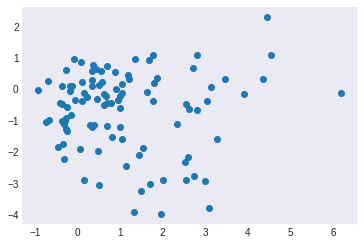

In [0]:
# use the generator to Generate n개의 fake examples, with Class Labels - Generator가 만드는 data는 다 fake겠지?
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = np.zeros((n, 1))
	return X, y 				# shape=((n,2),1)
	
# generate and plot fake samples
data = generate_fake_samples(g_model, 5, 100)

# plot fake samples
plt.scatter(data[0][:, 0], data[0][:, 1])
plt.show()

### 판별기 성능 검증 및 진짜와 가짜의 위치 시각화

Epoch:0   Acc_real:1.000000   Acc_fake:0.020000


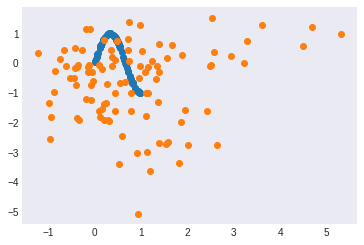

In [0]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, 
                          n=100, ovr=False):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
 
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
 
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
 
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	if ovr: 
		display.clear_output(wait=True)
	print("Epoch:%d   Acc_real:%f   Acc_fake:%f" % (epoch, acc_real, acc_fake))
	# scatter plot real and fake data points
	plt.scatter(x_real[:, 0], x_real[:, 1])
	plt.scatter(x_fake[:, 0], x_fake[:, 1])
	plt.show()

summarize_performance(0,g_model,d_model,5, ovr=True)
# 빨간 점으로 표현되는 것은 Real Data
# 파란 점으로 표현되는 것은 Fake Data

## 생성기와 판별기 학습 및 결과

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=512, n_eval=100, override=False):	# n_eval=100 : 100번에 한 번씩 보여달라는 의미!
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# Prepare real samples
		x_real, y_real = generate_real_samples(half_batch) 
		# Prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
	
		# update Discriminator	=> "D-Model을 Train 시키는 것!" : 얘는 진짜야 하면서 Real Data를 넣어주며 Training
		for j in range(3):
			d_model.train_on_batch(x_real, y_real)
			d_model.train_on_batch(x_fake, y_fake)
	
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples	=> Real이라고 Label 사기를 치는 것!
		y_gan = np.ones((n_batch, 1))
	
		# Update the Generator via the discriminator's error 	=> "G-Model을 Train 시키는 것!!"
		gan_model.train_on_batch(x_gan, y_gan)
	
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim, ovr=override)

9999 0.59 0.39  
CPU times: user 10min 50s, sys: 42.4 s, total: 11min 32s  
Wall time: 10min 6s  


Epoch:99   Acc_real:0.400000   Acc_fake:0.890000


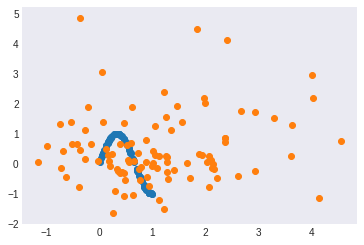

Epoch:199   Acc_real:0.830000   Acc_fake:0.450000


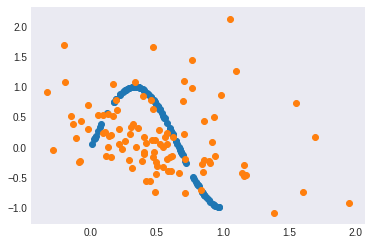

Epoch:299   Acc_real:0.790000   Acc_fake:0.480000


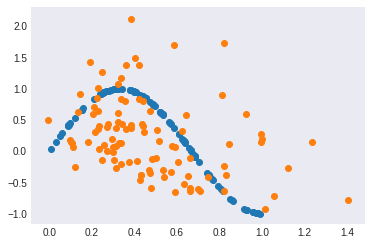

Epoch:399   Acc_real:0.740000   Acc_fake:0.530000


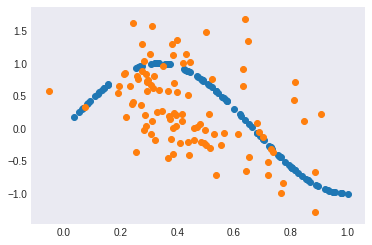

Epoch:499   Acc_real:0.640000   Acc_fake:0.580000


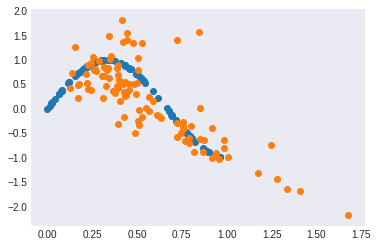

Epoch:599   Acc_real:0.460000   Acc_fake:0.610000


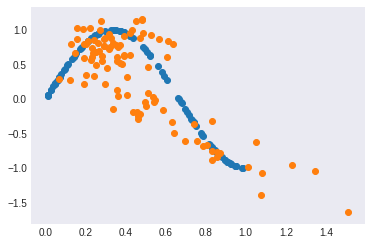

Epoch:699   Acc_real:0.390000   Acc_fake:0.680000


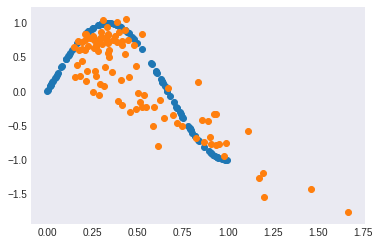

Epoch:799   Acc_real:0.270000   Acc_fake:0.930000


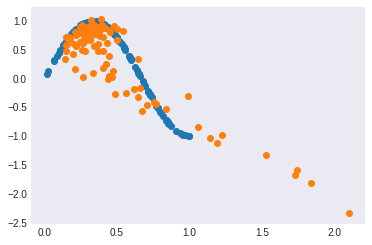

Epoch:899   Acc_real:0.310000   Acc_fake:0.910000


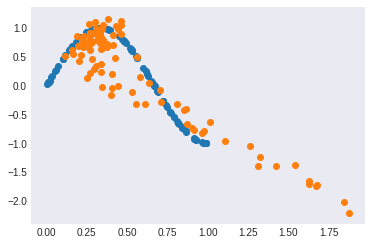

Epoch:999   Acc_real:0.280000   Acc_fake:0.810000


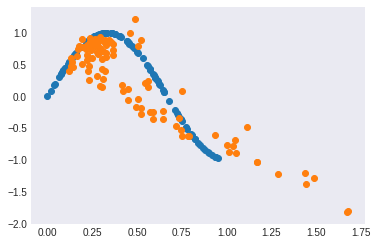

Epoch:1099   Acc_real:0.410000   Acc_fake:0.770000


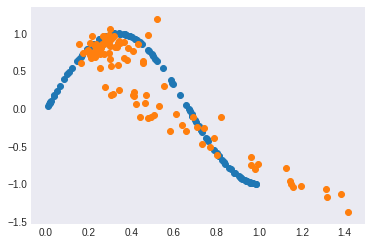

Epoch:1199   Acc_real:0.450000   Acc_fake:0.690000


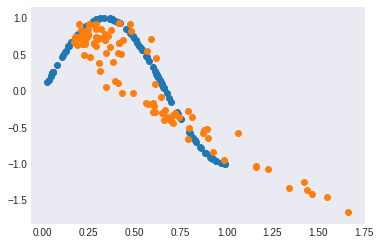

Epoch:1299   Acc_real:0.340000   Acc_fake:0.780000


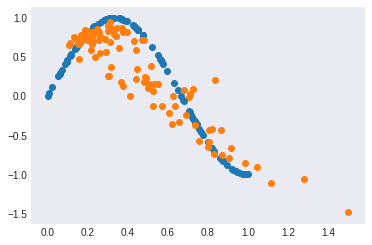

Epoch:1399   Acc_real:0.510000   Acc_fake:0.760000


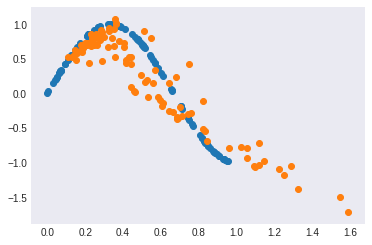

Epoch:1499   Acc_real:0.420000   Acc_fake:0.820000


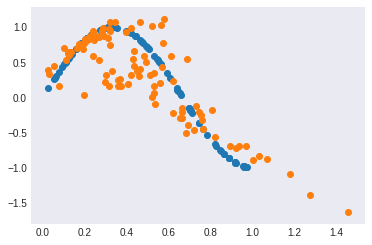

Epoch:1599   Acc_real:0.630000   Acc_fake:0.570000


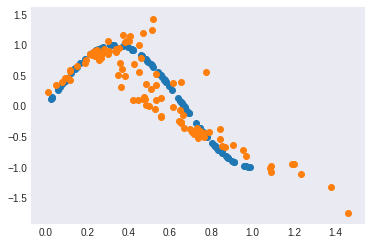

Epoch:1699   Acc_real:0.550000   Acc_fake:0.690000


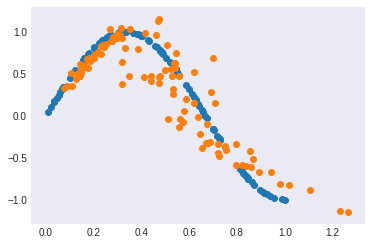

Epoch:1799   Acc_real:0.610000   Acc_fake:0.660000


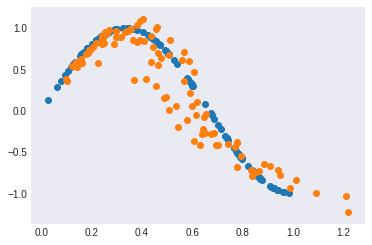

Epoch:1899   Acc_real:0.610000   Acc_fake:0.540000


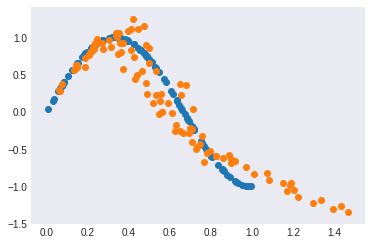

Epoch:1999   Acc_real:0.720000   Acc_fake:0.550000


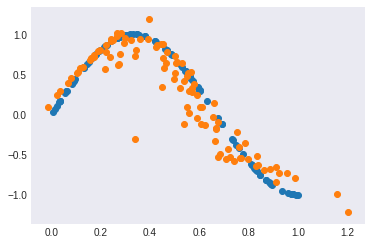

Epoch:2099   Acc_real:0.710000   Acc_fake:0.610000


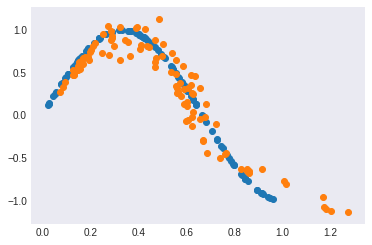

Epoch:2199   Acc_real:0.800000   Acc_fake:0.510000


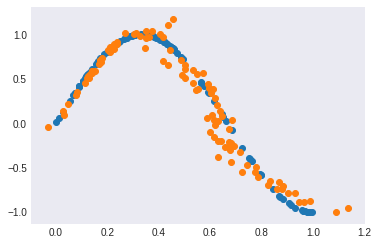

Epoch:2299   Acc_real:0.680000   Acc_fake:0.490000


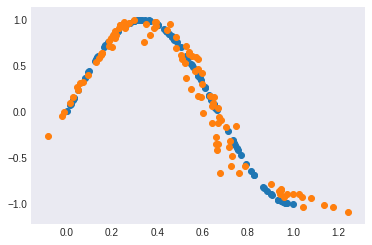

Epoch:2399   Acc_real:0.680000   Acc_fake:0.520000


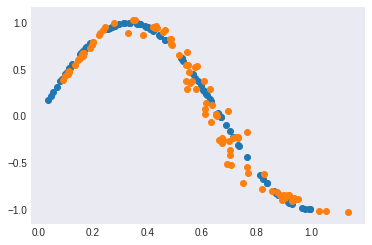

Epoch:2499   Acc_real:0.630000   Acc_fake:0.640000


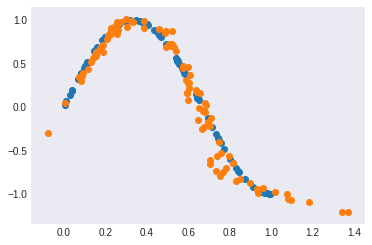

Epoch:2599   Acc_real:0.600000   Acc_fake:0.670000


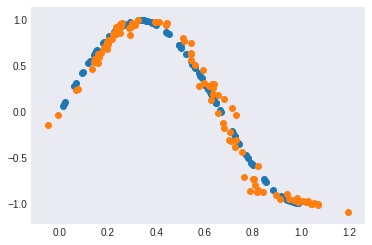

Epoch:2699   Acc_real:0.600000   Acc_fake:0.560000


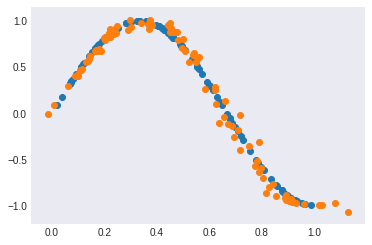

Epoch:2799   Acc_real:0.540000   Acc_fake:0.600000


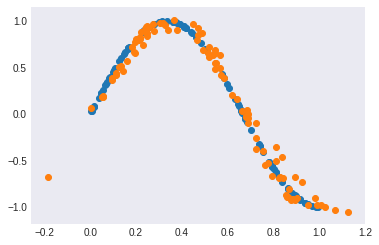

Epoch:2899   Acc_real:0.570000   Acc_fake:0.690000


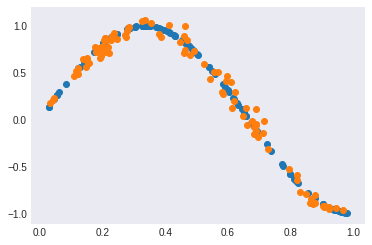

Epoch:2999   Acc_real:0.580000   Acc_fake:0.520000


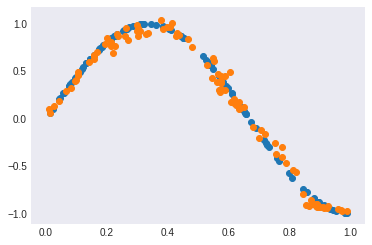

Epoch:3099   Acc_real:0.460000   Acc_fake:0.590000


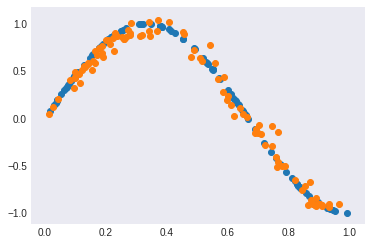

Epoch:3199   Acc_real:0.540000   Acc_fake:0.530000


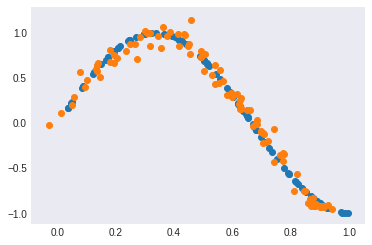

Epoch:3299   Acc_real:0.420000   Acc_fake:0.560000


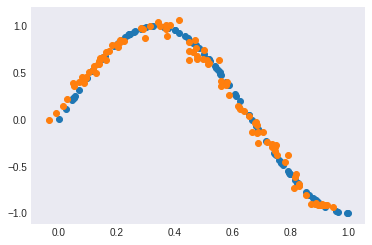

Epoch:3399   Acc_real:0.480000   Acc_fake:0.560000


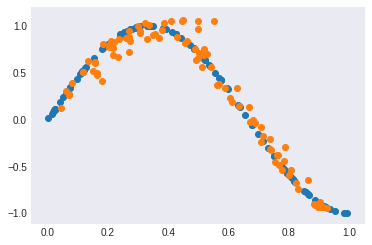

Epoch:3499   Acc_real:0.380000   Acc_fake:0.700000


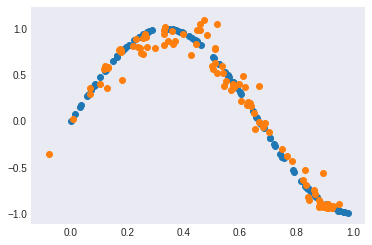

Epoch:3599   Acc_real:0.470000   Acc_fake:0.600000


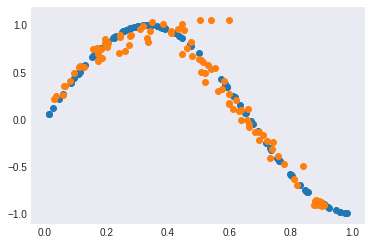

Epoch:3699   Acc_real:0.350000   Acc_fake:0.570000


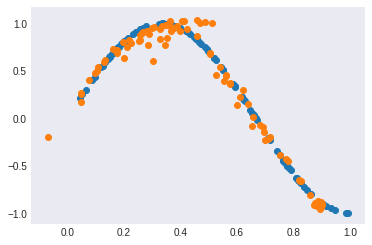

Epoch:3799   Acc_real:0.460000   Acc_fake:0.800000


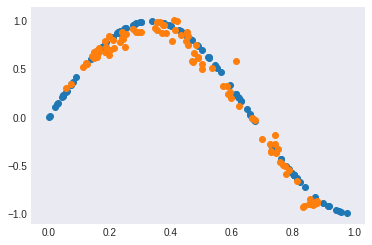

Epoch:3899   Acc_real:0.480000   Acc_fake:0.590000


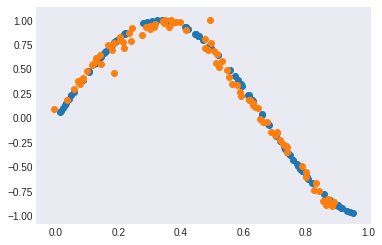

Epoch:3999   Acc_real:0.470000   Acc_fake:0.720000


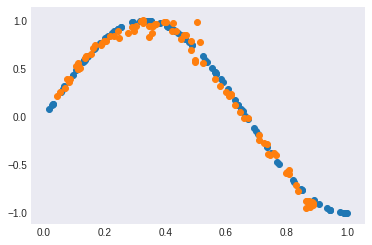

Epoch:4099   Acc_real:0.550000   Acc_fake:0.640000


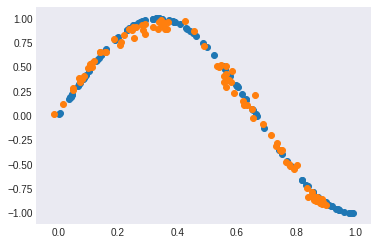

Epoch:4199   Acc_real:0.450000   Acc_fake:0.650000


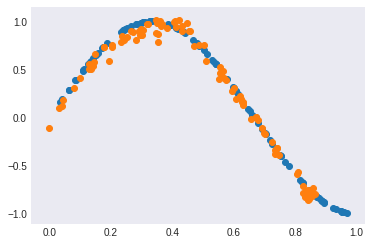

Epoch:4299   Acc_real:0.600000   Acc_fake:0.610000


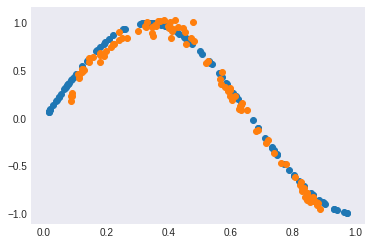

Epoch:4399   Acc_real:0.550000   Acc_fake:0.460000


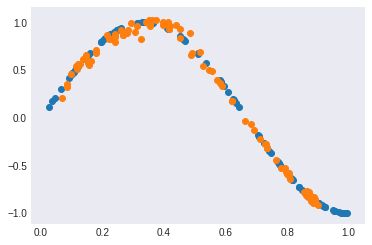

Epoch:4499   Acc_real:0.520000   Acc_fake:0.810000


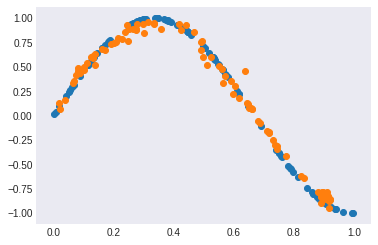

Epoch:4599   Acc_real:0.500000   Acc_fake:0.690000


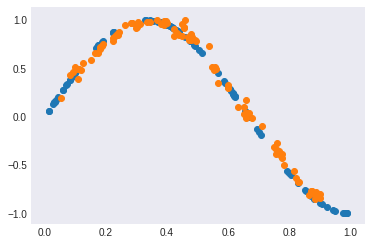

Epoch:4699   Acc_real:0.470000   Acc_fake:0.590000


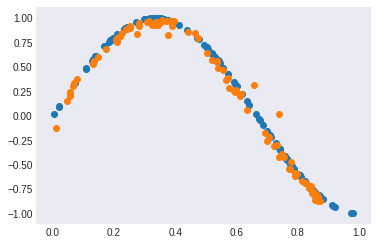

Epoch:4799   Acc_real:0.600000   Acc_fake:0.560000


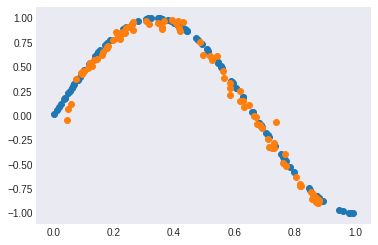

Epoch:4899   Acc_real:0.360000   Acc_fake:0.660000


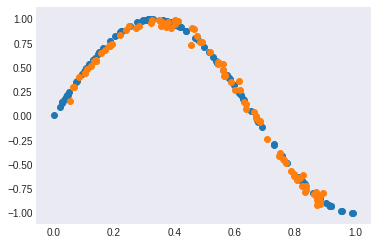

Epoch:4999   Acc_real:0.550000   Acc_fake:0.430000


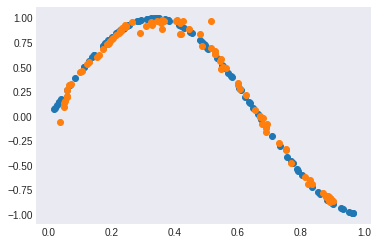

Epoch:5099   Acc_real:0.440000   Acc_fake:0.700000


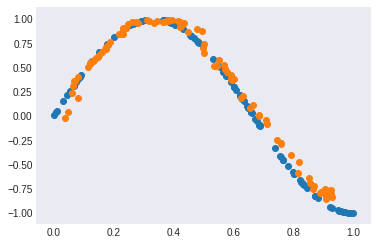

Epoch:5199   Acc_real:0.440000   Acc_fake:0.580000


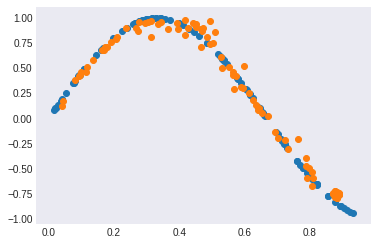

Epoch:5299   Acc_real:0.400000   Acc_fake:0.720000


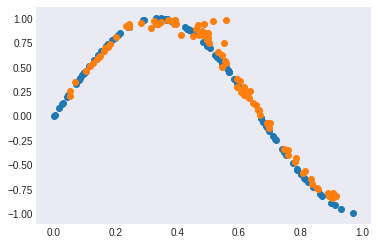

Epoch:5399   Acc_real:0.240000   Acc_fake:0.680000


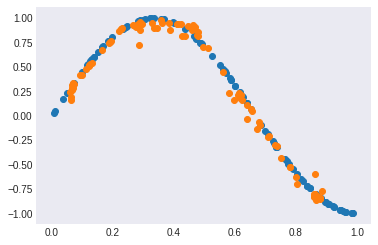

Epoch:5499   Acc_real:0.440000   Acc_fake:0.670000


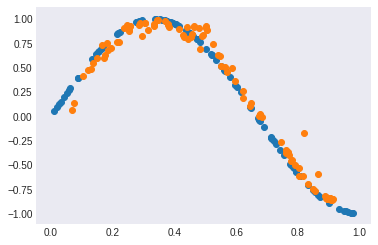

Epoch:5599   Acc_real:0.370000   Acc_fake:0.710000


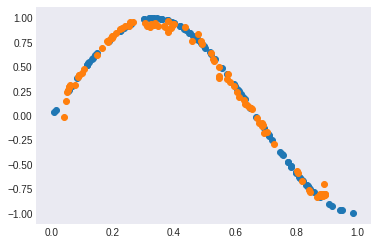

Epoch:5699   Acc_real:0.410000   Acc_fake:0.720000


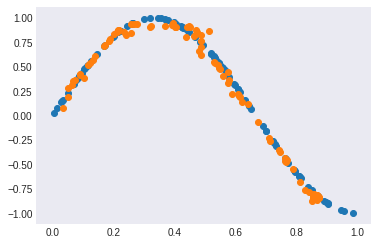

Epoch:5799   Acc_real:0.510000   Acc_fake:0.630000


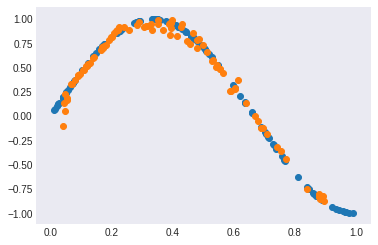

Epoch:5899   Acc_real:0.520000   Acc_fake:0.690000


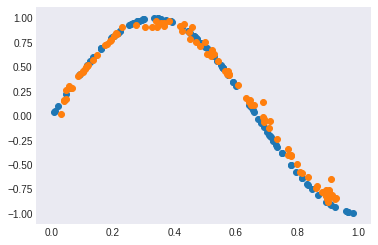

Epoch:5999   Acc_real:0.500000   Acc_fake:0.530000


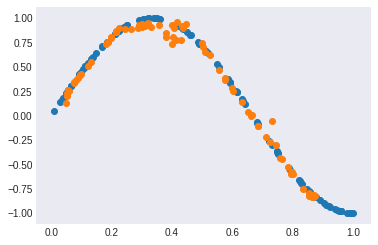

Epoch:6099   Acc_real:0.480000   Acc_fake:0.510000


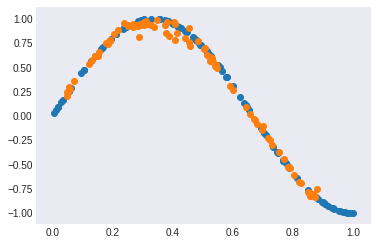

Epoch:6199   Acc_real:0.510000   Acc_fake:0.760000


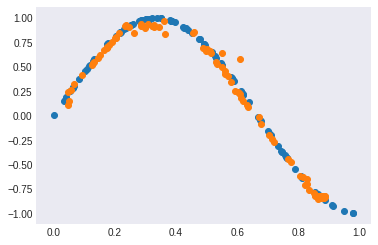

Epoch:6299   Acc_real:0.510000   Acc_fake:0.550000


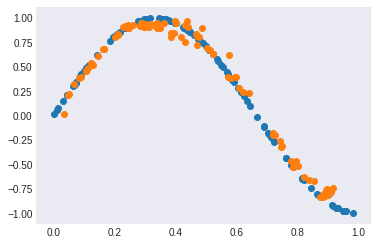

Epoch:6399   Acc_real:0.410000   Acc_fake:0.620000


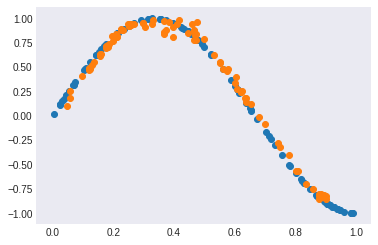

Epoch:6499   Acc_real:0.650000   Acc_fake:0.460000


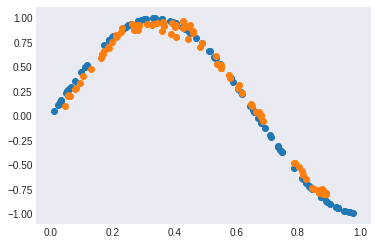

Epoch:6599   Acc_real:0.380000   Acc_fake:0.630000


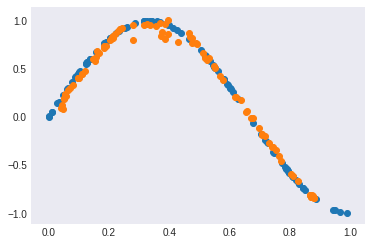

Epoch:6699   Acc_real:0.540000   Acc_fake:0.410000


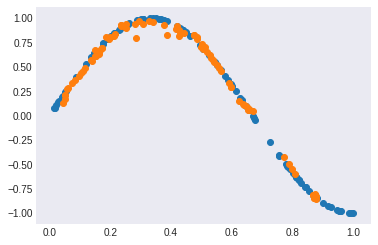

Epoch:6799   Acc_real:0.490000   Acc_fake:0.610000


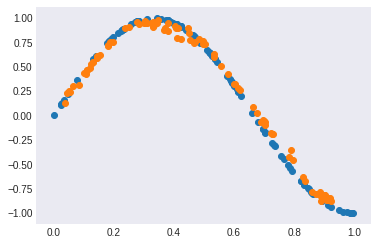

Epoch:6899   Acc_real:0.470000   Acc_fake:0.640000


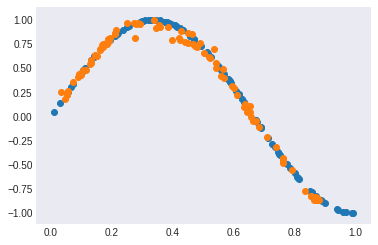

Epoch:6999   Acc_real:0.430000   Acc_fake:0.520000


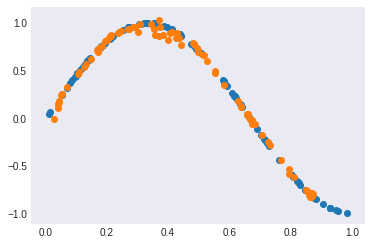

Epoch:7099   Acc_real:0.570000   Acc_fake:0.450000


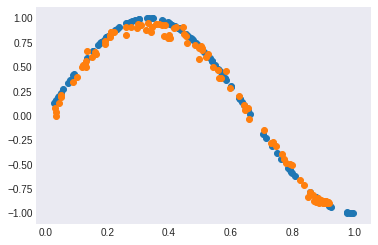

Epoch:7199   Acc_real:0.540000   Acc_fake:0.480000


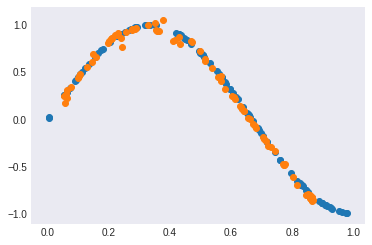

Epoch:7299   Acc_real:0.530000   Acc_fake:0.460000


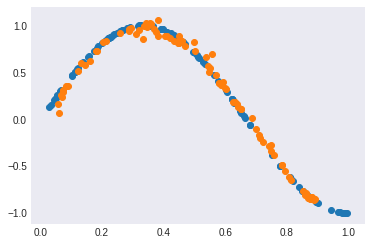

Epoch:7399   Acc_real:0.500000   Acc_fake:0.600000


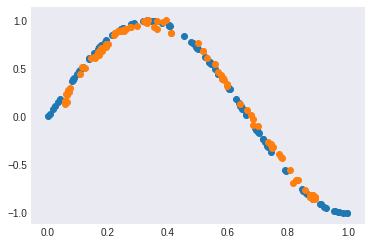

Epoch:7499   Acc_real:0.530000   Acc_fake:0.420000


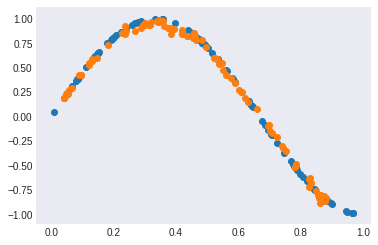

Epoch:7599   Acc_real:0.590000   Acc_fake:0.690000


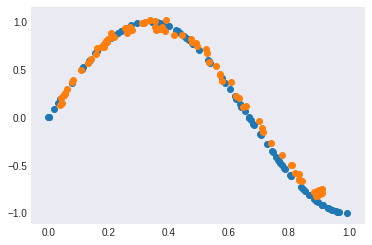

Epoch:7699   Acc_real:0.630000   Acc_fake:0.540000


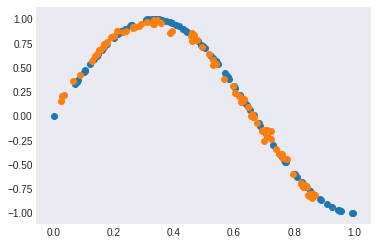

Epoch:7799   Acc_real:0.490000   Acc_fake:0.610000


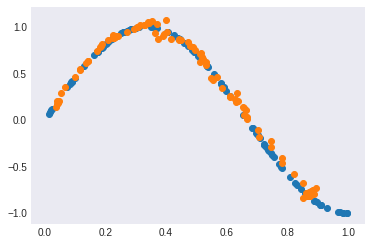

Epoch:7899   Acc_real:0.510000   Acc_fake:0.540000


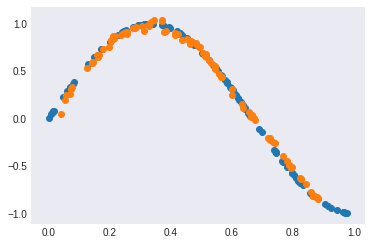

Epoch:7999   Acc_real:0.730000   Acc_fake:0.470000


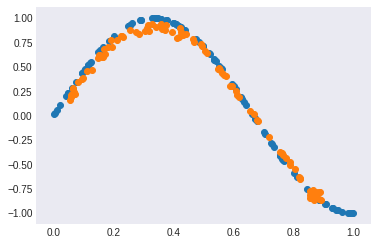

Epoch:8099   Acc_real:0.720000   Acc_fake:0.580000


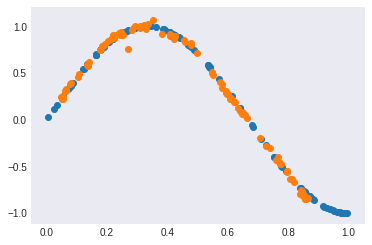

Epoch:8199   Acc_real:0.400000   Acc_fake:0.660000


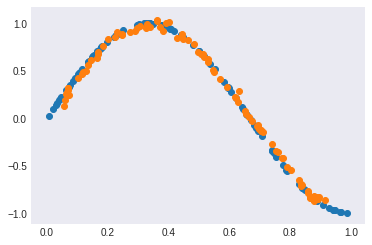

Epoch:8299   Acc_real:0.730000   Acc_fake:0.510000


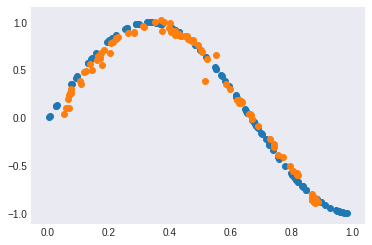

Epoch:8399   Acc_real:0.510000   Acc_fake:0.610000


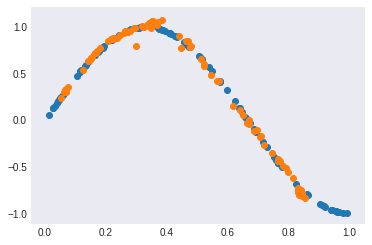

Epoch:8499   Acc_real:0.650000   Acc_fake:0.560000


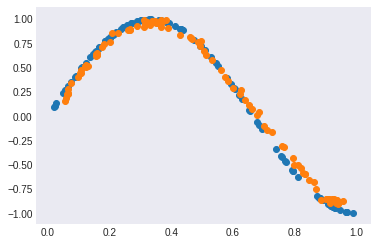

Epoch:8599   Acc_real:0.570000   Acc_fake:0.530000


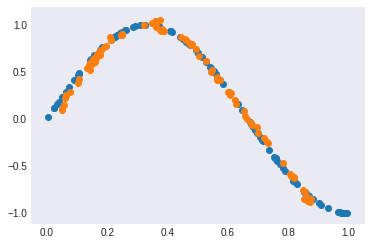

Epoch:8699   Acc_real:0.350000   Acc_fake:0.790000


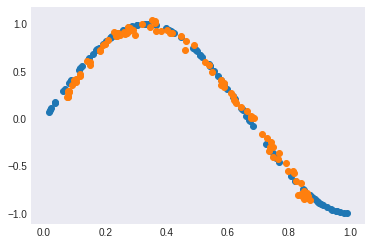

Epoch:8799   Acc_real:0.580000   Acc_fake:0.500000


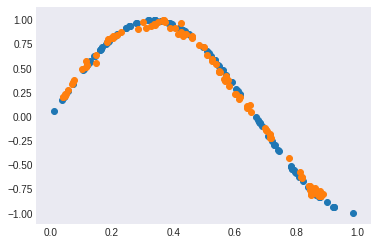

Epoch:8899   Acc_real:0.510000   Acc_fake:0.630000


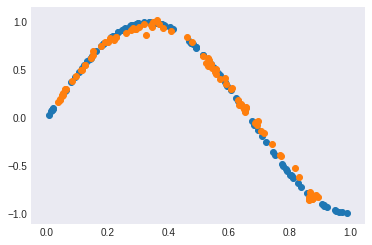

Epoch:8999   Acc_real:0.620000   Acc_fake:0.440000


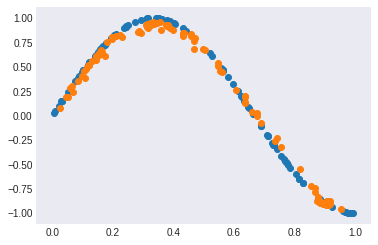

Epoch:9099   Acc_real:0.800000   Acc_fake:0.410000


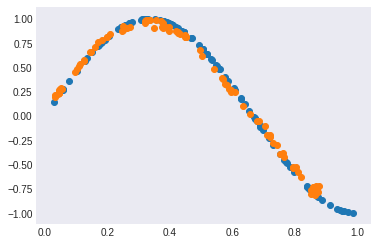

Epoch:9199   Acc_real:0.580000   Acc_fake:0.560000


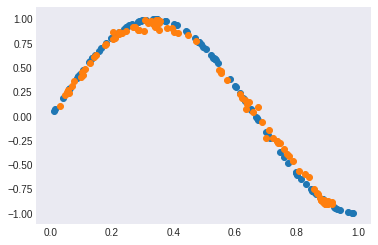

Epoch:9299   Acc_real:0.460000   Acc_fake:0.460000


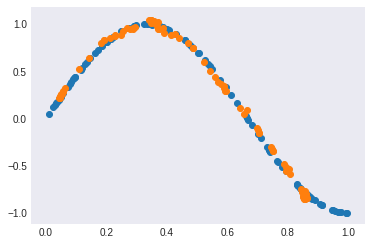

Epoch:9399   Acc_real:0.620000   Acc_fake:0.440000


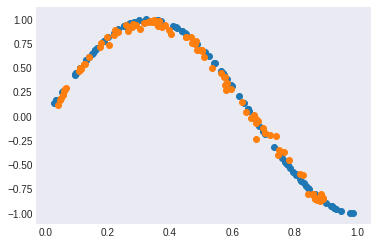

Epoch:9499   Acc_real:0.720000   Acc_fake:0.630000


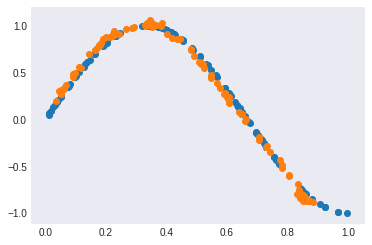

Epoch:9599   Acc_real:0.770000   Acc_fake:0.390000


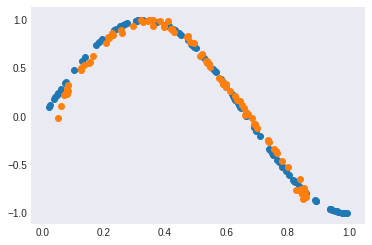

Epoch:9699   Acc_real:0.780000   Acc_fake:0.590000


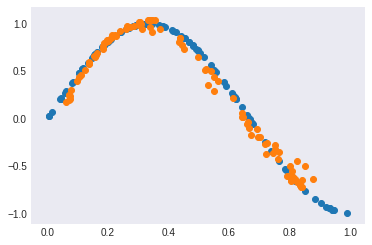

Epoch:9799   Acc_real:0.620000   Acc_fake:0.570000


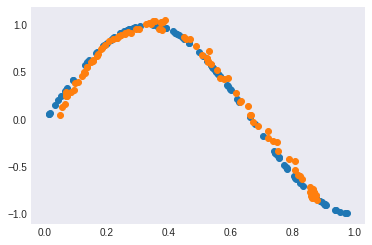

Epoch:9899   Acc_real:0.540000   Acc_fake:0.490000


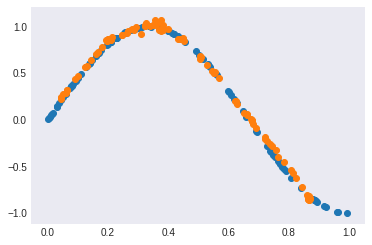

Epoch:9999   Acc_real:0.700000   Acc_fake:0.430000


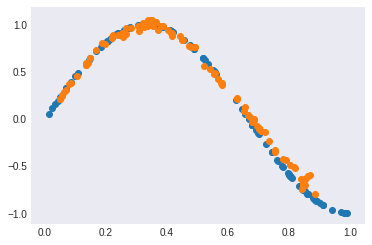

CPU times: user 17min 56s, sys: 1min 14s, total: 19min 11s
Wall time: 15min 54s


In [0]:
%%time
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
  
# train model: override=True -> 같은 위치에 plot
train(generator, discriminator, gan_model, latent_dim) # 파라미터로 n_epochs는 default가 10000이므로, 10000번 전체 훈련을 함!


In [0]:
gan_model.save('/content/drive/Shared drives/scsa_2019_c/07_kyn/models/model_simple_gan_7_kyn_191211.hdf5')
gan_model.save_weights('/content/drive/Shared drives/scsa_2019_c/07_kyn/models/model_simple_gan_7_kyn_191211.h5')

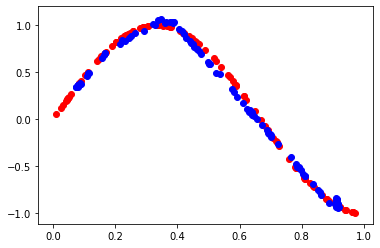

In [0]:
test_model = tf.keras.models.load_model('/content/drive/Shared drives/scsa_2019_c/07_kyn/models/model_simple_gan_7_kyn_191211.hdf5')

## **실습 과제**

### 과제1

- #### 결과가 만족스러운가? 더 개선할 수 있을까? (GAN 모델은 학습이 쉽지 않음)
- #### Latent space vector를 늘리면? latent_dim = ??
- #### 학습에 사용되는 batch size를 늘리면? n=batch = ??
- #### D 모델 학습을 한번 더 시키면? 





Epoch:99   Acc_real:0.400000   Acc_fake:0.780000


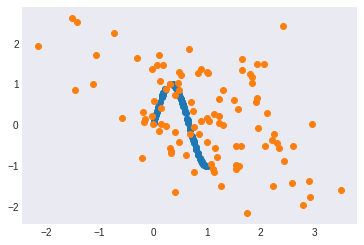

Epoch:199   Acc_real:0.570000   Acc_fake:0.800000


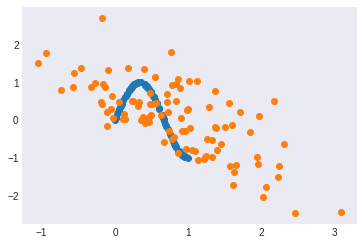

Epoch:299   Acc_real:0.480000   Acc_fake:0.760000


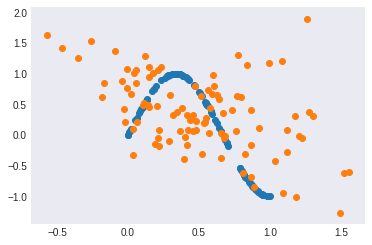

Epoch:399   Acc_real:0.750000   Acc_fake:0.510000


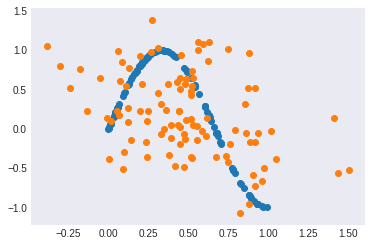

Epoch:499   Acc_real:0.720000   Acc_fake:0.260000


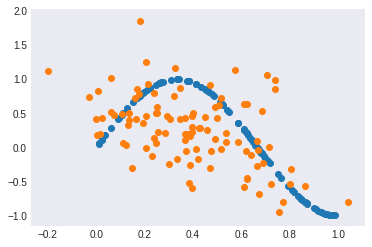

Epoch:599   Acc_real:0.770000   Acc_fake:0.200000


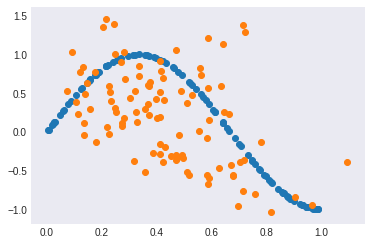

Epoch:699   Acc_real:0.800000   Acc_fake:0.440000


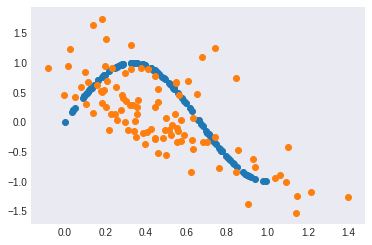

Epoch:799   Acc_real:0.670000   Acc_fake:0.400000


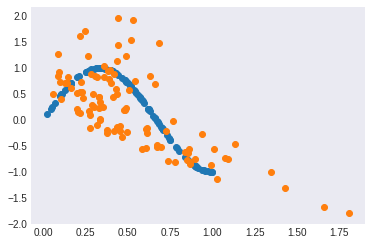

Epoch:899   Acc_real:0.630000   Acc_fake:0.390000


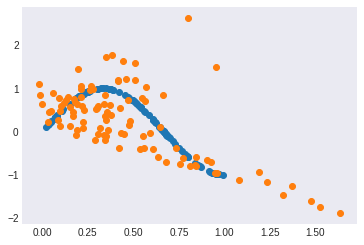

Epoch:999   Acc_real:0.640000   Acc_fake:0.460000


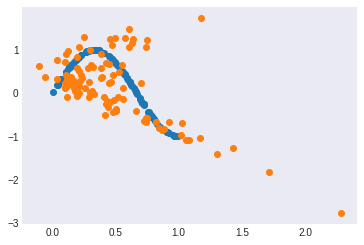

Epoch:1099   Acc_real:0.630000   Acc_fake:0.400000


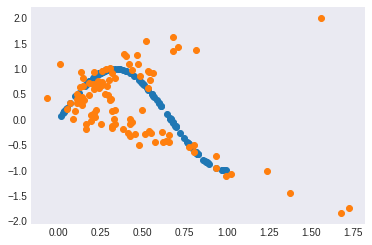

Epoch:1199   Acc_real:0.580000   Acc_fake:0.400000


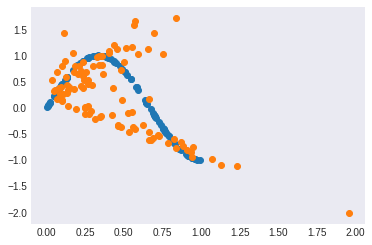

Epoch:1299   Acc_real:0.760000   Acc_fake:0.380000


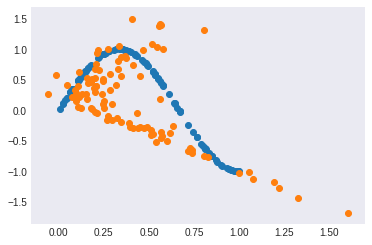

Epoch:1399   Acc_real:0.550000   Acc_fake:0.270000


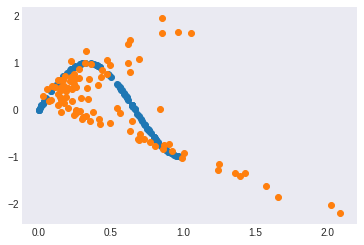

Epoch:1499   Acc_real:0.640000   Acc_fake:0.310000


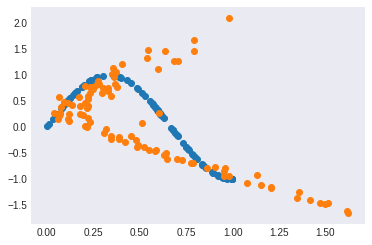

Epoch:1599   Acc_real:0.720000   Acc_fake:0.330000


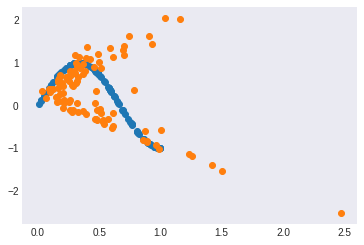

Epoch:1699   Acc_real:0.750000   Acc_fake:0.220000


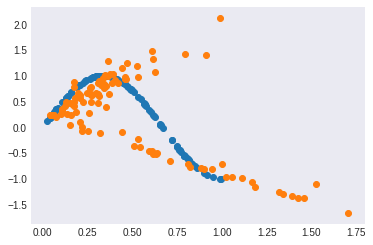

Epoch:1799   Acc_real:0.710000   Acc_fake:0.270000


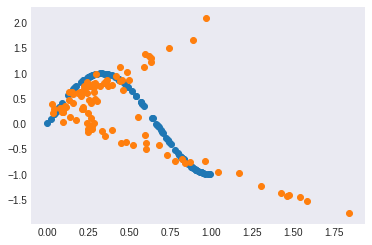

Epoch:1899   Acc_real:0.800000   Acc_fake:0.370000


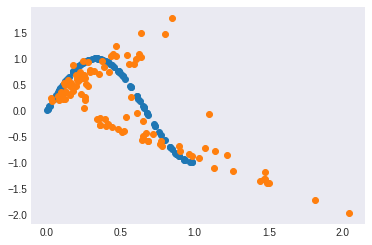

Epoch:1999   Acc_real:0.750000   Acc_fake:0.300000


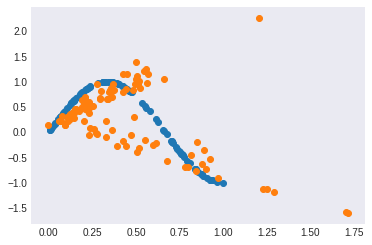

Epoch:2099   Acc_real:0.780000   Acc_fake:0.460000


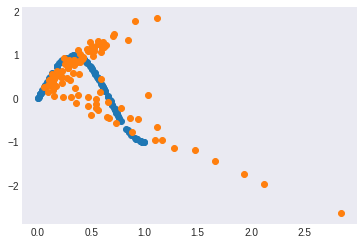

Epoch:2199   Acc_real:0.710000   Acc_fake:0.250000


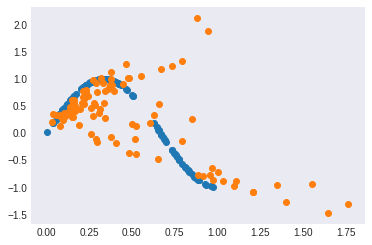

Epoch:2299   Acc_real:0.420000   Acc_fake:0.640000


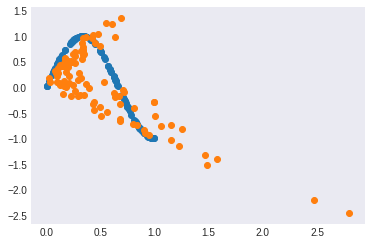

Epoch:2399   Acc_real:0.280000   Acc_fake:0.870000


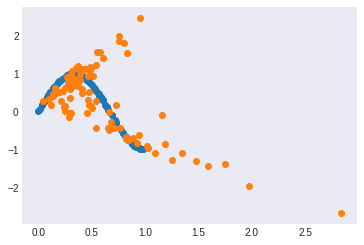

Epoch:2499   Acc_real:0.740000   Acc_fake:0.290000


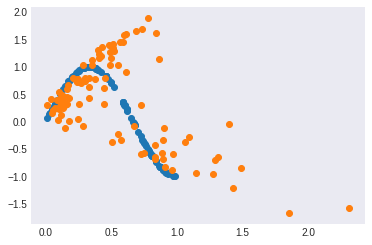

Epoch:2599   Acc_real:0.840000   Acc_fake:0.400000


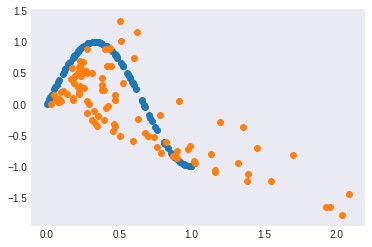

Epoch:2699   Acc_real:0.200000   Acc_fake:0.880000


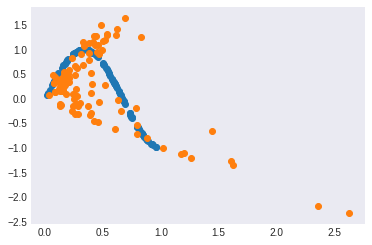

Epoch:2799   Acc_real:0.670000   Acc_fake:0.370000


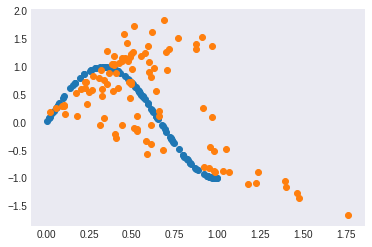

Epoch:2899   Acc_real:0.840000   Acc_fake:0.200000


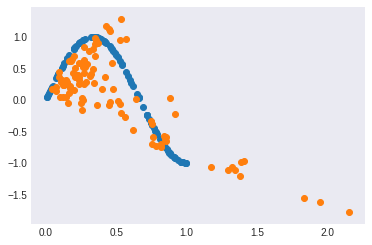

Epoch:2999   Acc_real:0.190000   Acc_fake:0.850000


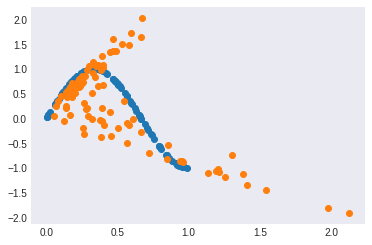

Epoch:3099   Acc_real:0.670000   Acc_fake:0.320000


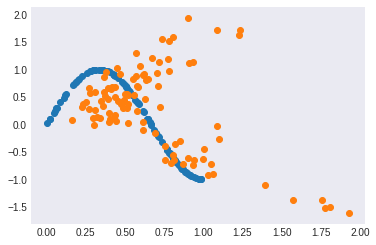

Epoch:3199   Acc_real:0.490000   Acc_fake:0.690000


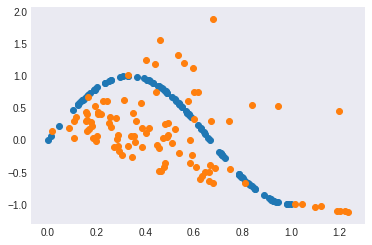

Epoch:3299   Acc_real:0.190000   Acc_fake:0.810000


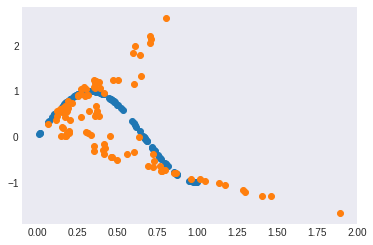

Epoch:3399   Acc_real:0.780000   Acc_fake:0.220000


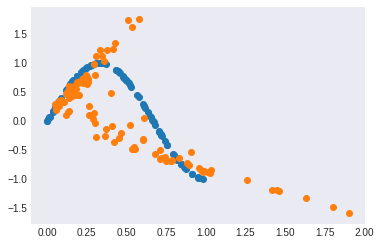

Epoch:3499   Acc_real:0.360000   Acc_fake:0.730000


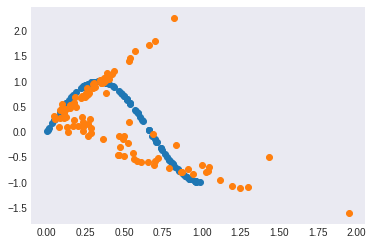

Epoch:3599   Acc_real:0.850000   Acc_fake:0.430000


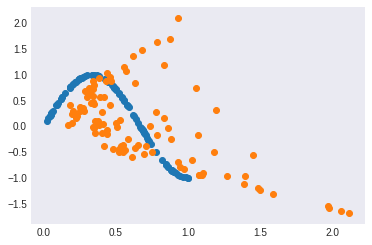

Epoch:3699   Acc_real:0.450000   Acc_fake:1.000000


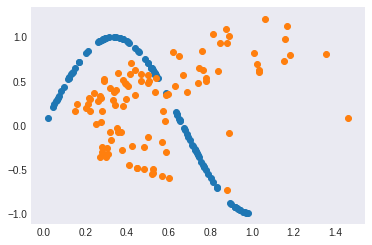

Epoch:3799   Acc_real:0.500000   Acc_fake:0.410000


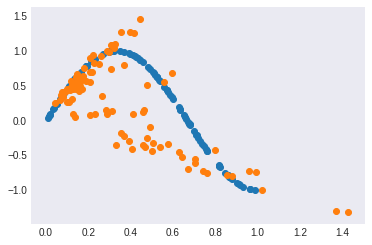

Epoch:3899   Acc_real:0.620000   Acc_fake:0.300000


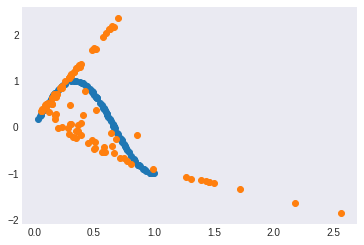

Epoch:3999   Acc_real:0.740000   Acc_fake:0.460000


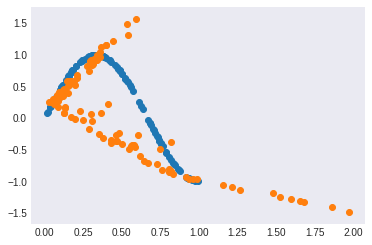

Epoch:4099   Acc_real:0.370000   Acc_fake:0.830000


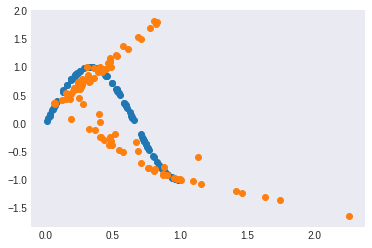

Epoch:4199   Acc_real:0.900000   Acc_fake:0.150000


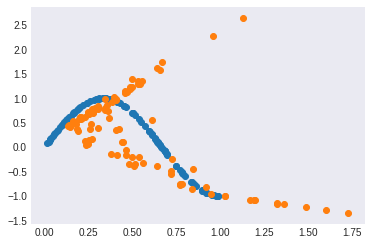

Epoch:4299   Acc_real:0.480000   Acc_fake:0.660000


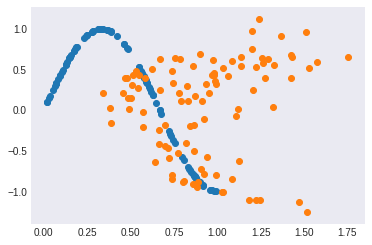

Epoch:4399   Acc_real:0.450000   Acc_fake:0.780000


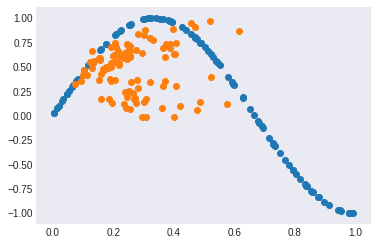

Epoch:4499   Acc_real:0.990000   Acc_fake:0.040000


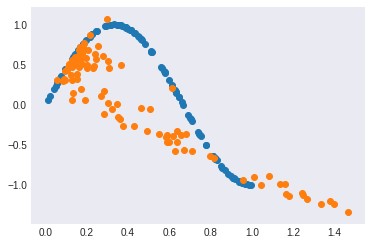

Epoch:4599   Acc_real:0.230000   Acc_fake:0.700000


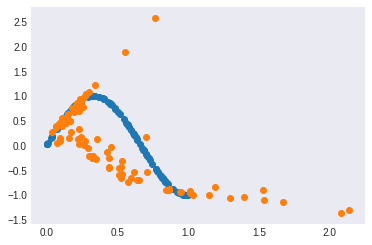

Epoch:4699   Acc_real:0.670000   Acc_fake:0.480000


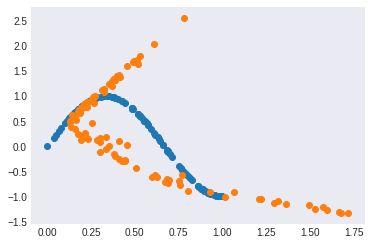

Epoch:4799   Acc_real:0.210000   Acc_fake:0.860000


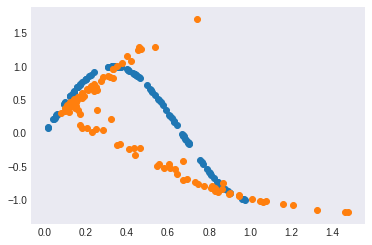

Epoch:4899   Acc_real:0.300000   Acc_fake:0.760000


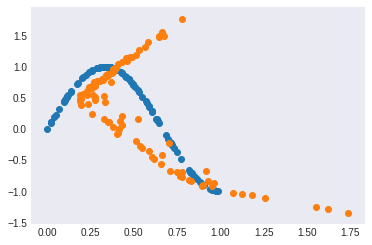

Epoch:4999   Acc_real:0.310000   Acc_fake:0.800000


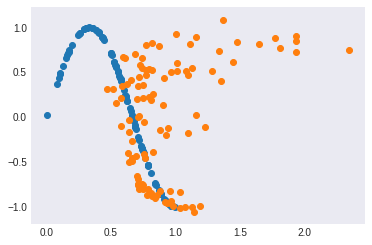

Epoch:5099   Acc_real:0.450000   Acc_fake:0.860000


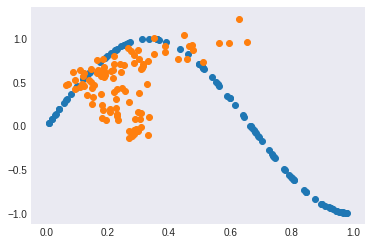

Epoch:5199   Acc_real:0.970000   Acc_fake:0.000000


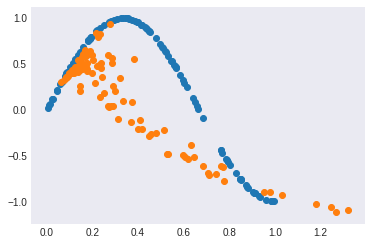

Epoch:5299   Acc_real:0.230000   Acc_fake:0.720000


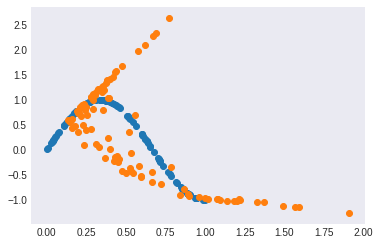

Epoch:5399   Acc_real:0.660000   Acc_fake:0.440000


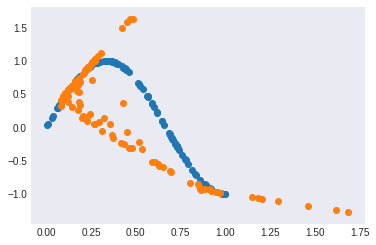

Epoch:5499   Acc_real:0.150000   Acc_fake:0.920000


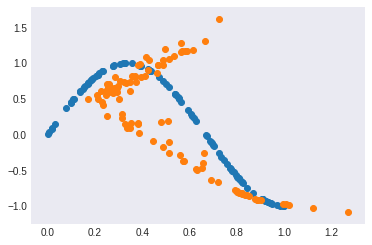

Epoch:5599   Acc_real:0.730000   Acc_fake:0.400000


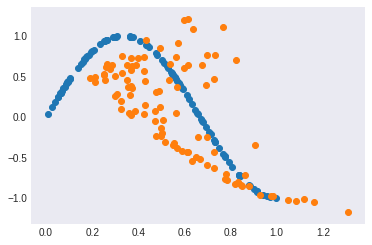

Epoch:5699   Acc_real:0.350000   Acc_fake:0.940000


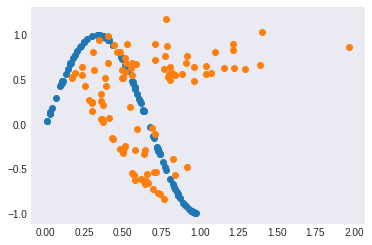

Epoch:5799   Acc_real:0.550000   Acc_fake:0.230000


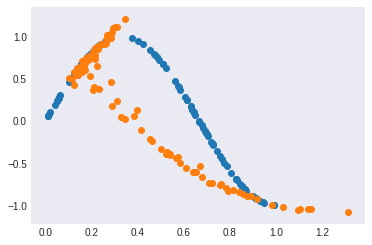

Epoch:5899   Acc_real:0.800000   Acc_fake:0.180000


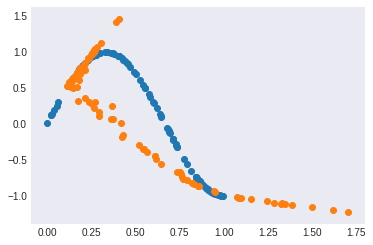

Epoch:5999   Acc_real:0.860000   Acc_fake:0.230000


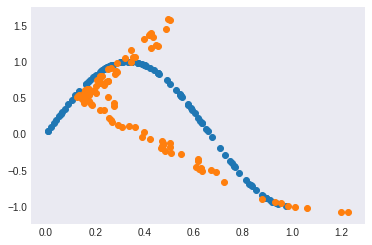

Epoch:6099   Acc_real:0.450000   Acc_fake:0.500000


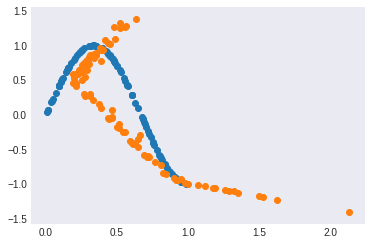

Epoch:6199   Acc_real:0.390000   Acc_fake:0.820000


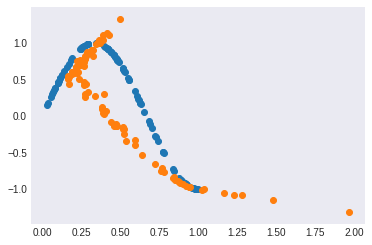

Epoch:6299   Acc_real:0.460000   Acc_fake:0.620000


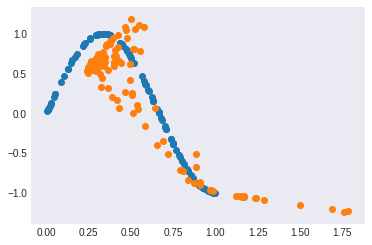

Epoch:6399   Acc_real:0.070000   Acc_fake:1.000000


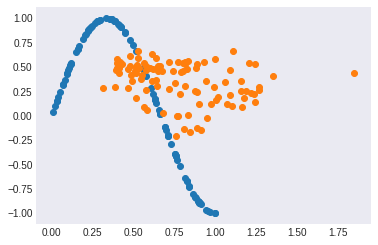

Epoch:6499   Acc_real:0.400000   Acc_fake:0.590000


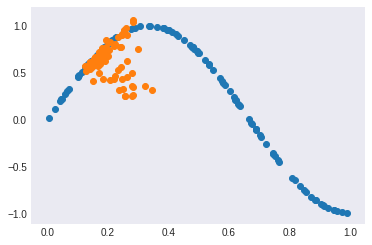

Epoch:6599   Acc_real:0.940000   Acc_fake:0.070000


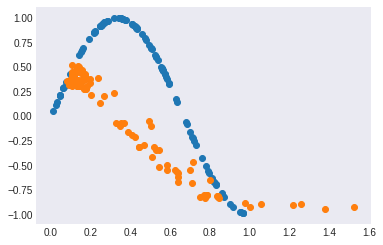

Epoch:6699   Acc_real:0.180000   Acc_fake:0.850000


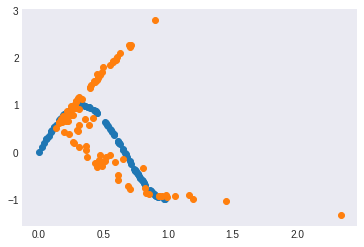

Epoch:6799   Acc_real:0.000000   Acc_fake:0.970000


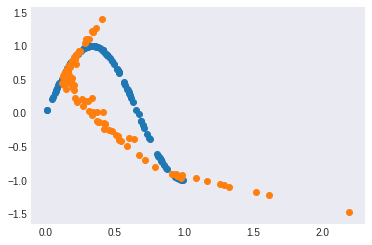

Epoch:6899   Acc_real:0.360000   Acc_fake:0.860000


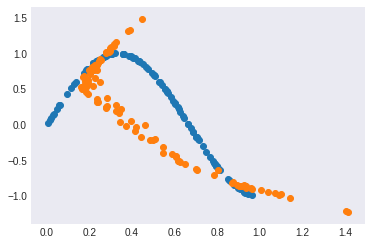

Epoch:6999   Acc_real:0.630000   Acc_fake:0.510000


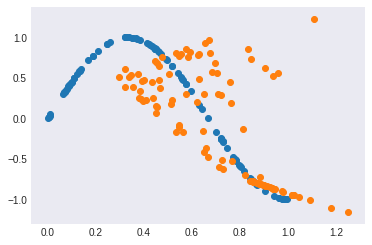

Epoch:7099   Acc_real:0.360000   Acc_fake:1.000000


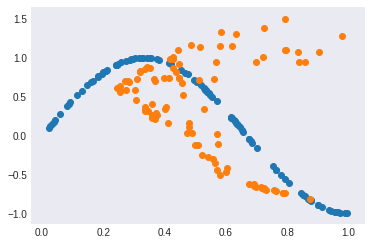

Epoch:7199   Acc_real:0.210000   Acc_fake:0.920000


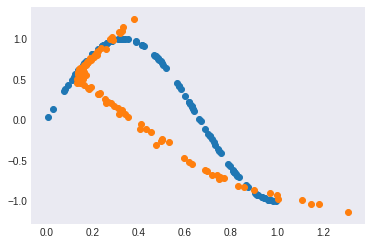

Epoch:7299   Acc_real:0.880000   Acc_fake:0.120000


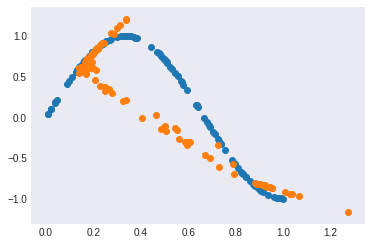

Epoch:7399   Acc_real:0.740000   Acc_fake:0.180000


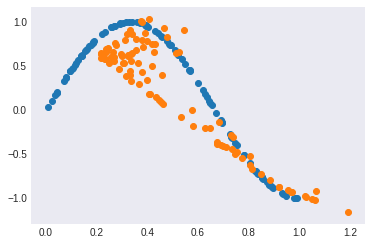

Epoch:7499   Acc_real:0.400000   Acc_fake:0.860000


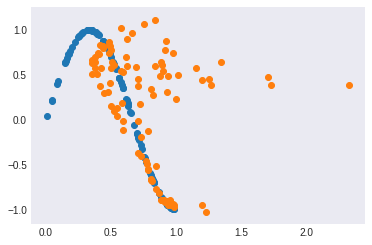

Epoch:7599   Acc_real:0.210000   Acc_fake:0.980000


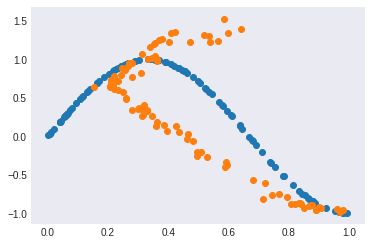

Epoch:7699   Acc_real:0.700000   Acc_fake:0.170000


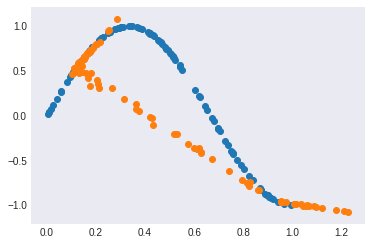

Epoch:7799   Acc_real:0.920000   Acc_fake:0.040000


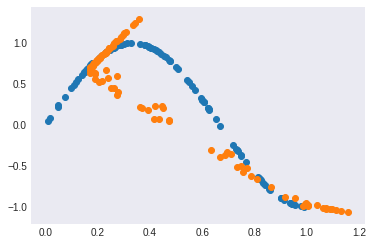

Epoch:7899   Acc_real:0.620000   Acc_fake:0.460000


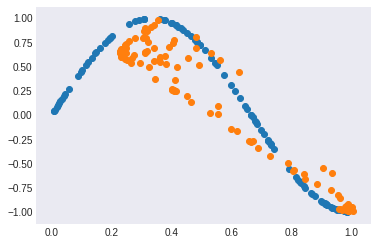

Epoch:7999   Acc_real:0.430000   Acc_fake:0.880000


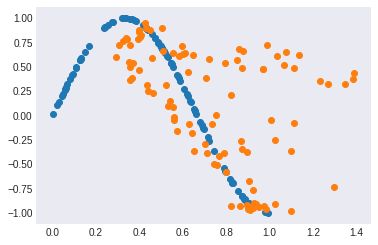

Epoch:8099   Acc_real:0.200000   Acc_fake:0.900000


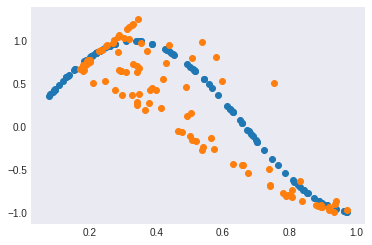

Epoch:8199   Acc_real:0.710000   Acc_fake:0.250000


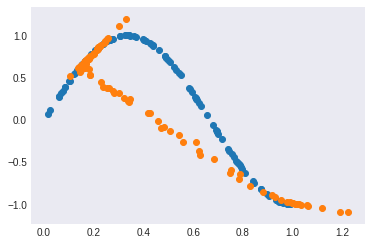

Epoch:8299   Acc_real:0.800000   Acc_fake:0.110000


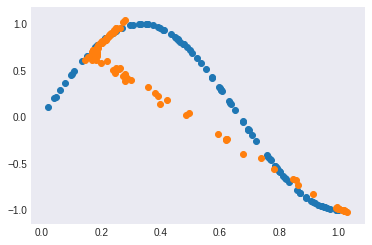

Epoch:8399   Acc_real:0.650000   Acc_fake:0.580000


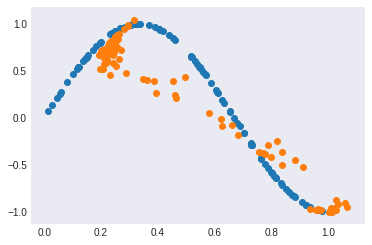

Epoch:8499   Acc_real:0.170000   Acc_fake:1.000000


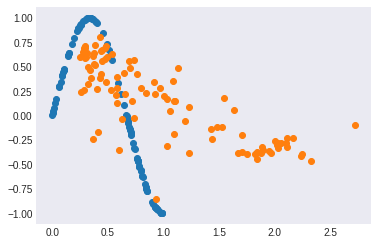

Epoch:8599   Acc_real:0.680000   Acc_fake:0.350000


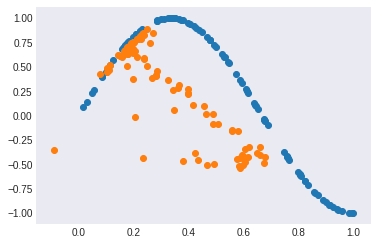

Epoch:8699   Acc_real:0.250000   Acc_fake:0.830000


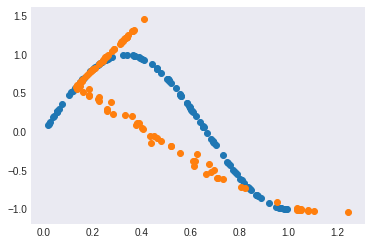

Epoch:8799   Acc_real:0.250000   Acc_fake:1.000000


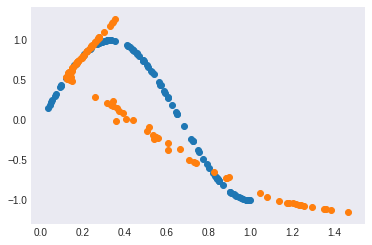

Epoch:8899   Acc_real:0.420000   Acc_fake:0.520000


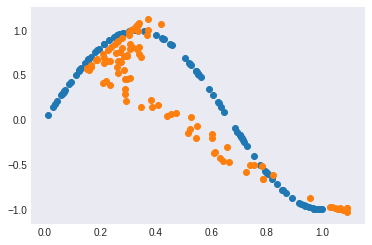

Epoch:8999   Acc_real:0.320000   Acc_fake:0.530000


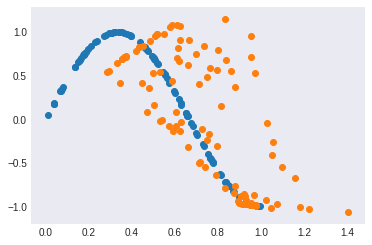

Epoch:9099   Acc_real:0.220000   Acc_fake:1.000000


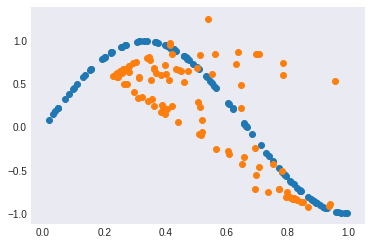

Epoch:9199   Acc_real:0.550000   Acc_fake:0.300000


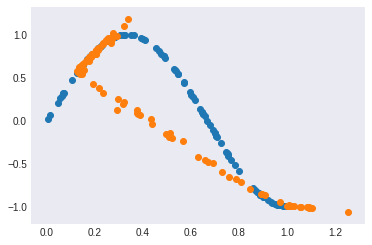

Epoch:9299   Acc_real:0.890000   Acc_fake:0.100000


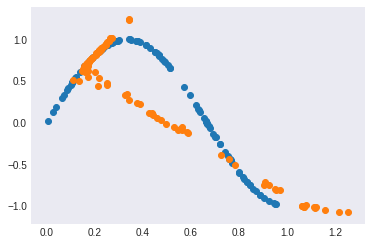

Epoch:9399   Acc_real:0.230000   Acc_fake:1.000000


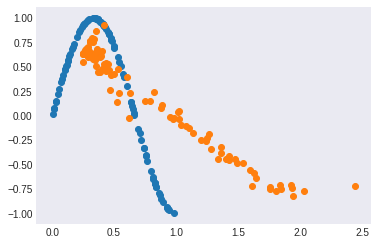

Epoch:9499   Acc_real:0.600000   Acc_fake:0.440000


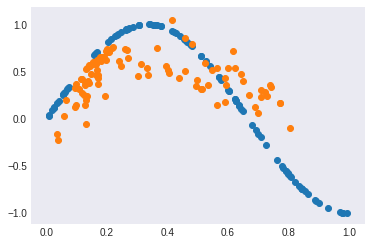

Epoch:9599   Acc_real:0.610000   Acc_fake:0.610000


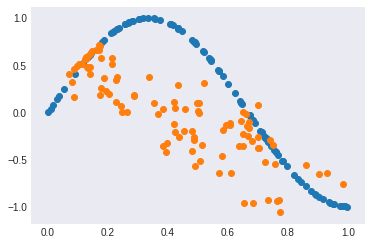

Epoch:9699   Acc_real:0.580000   Acc_fake:0.420000


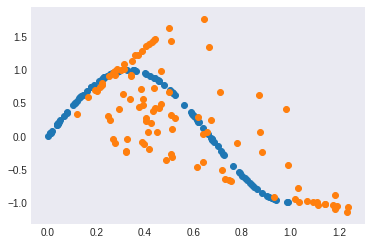

Epoch:9799   Acc_real:0.150000   Acc_fake:0.800000


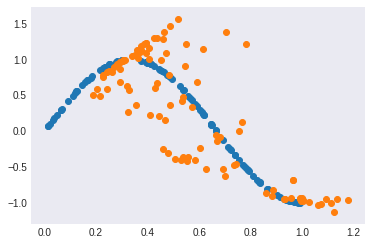

Epoch:9899   Acc_real:0.000000   Acc_fake:1.000000


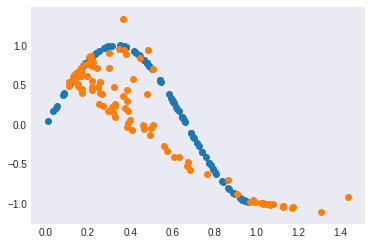

Epoch:9999   Acc_real:0.280000   Acc_fake:0.790000


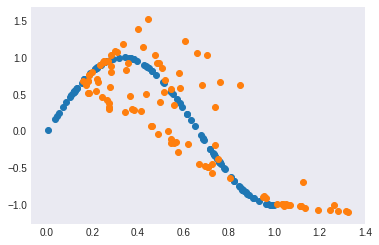

CPU times: user 8min 41s, sys: 40.4 s, total: 9min 22s
Wall time: 7min 44s


In [0]:
# latent_dim을 10으로 늘려서 해봄!
%%time
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

# train model: override=True -> 같은 위치에 plot
train(generator, discriminator, gan_model, latent_dim)


Epoch:99   Acc_real:1.000000   Acc_fake:0.660000


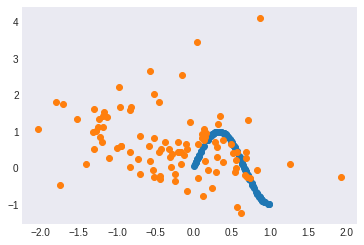

Epoch:199   Acc_real:0.400000   Acc_fake:0.610000


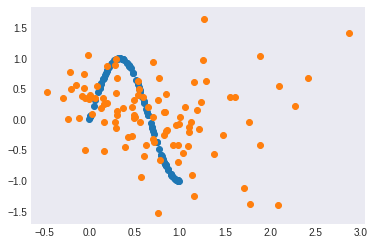

Epoch:299   Acc_real:0.640000   Acc_fake:0.490000


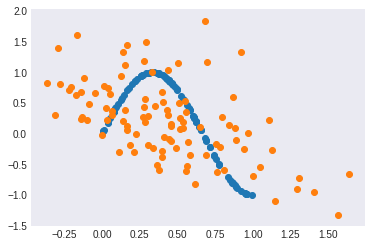

Epoch:399   Acc_real:0.550000   Acc_fake:0.560000


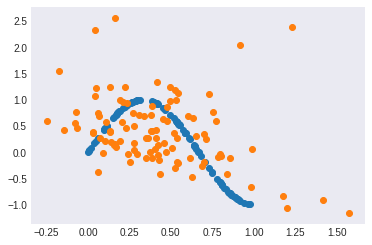

Epoch:499   Acc_real:0.740000   Acc_fake:0.480000


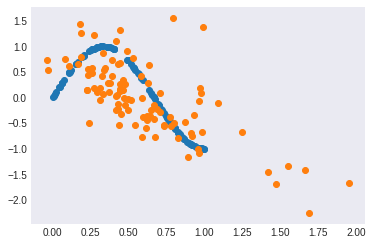

Epoch:599   Acc_real:0.630000   Acc_fake:0.650000


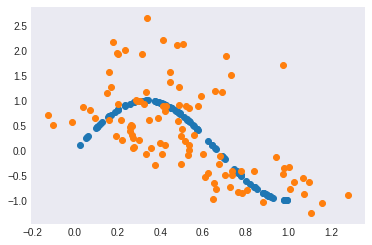

Epoch:699   Acc_real:0.430000   Acc_fake:0.780000


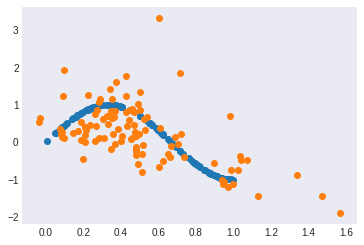

Epoch:799   Acc_real:0.440000   Acc_fake:0.760000


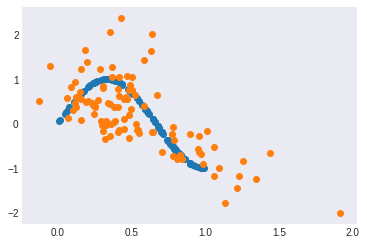

Epoch:899   Acc_real:0.400000   Acc_fake:0.870000


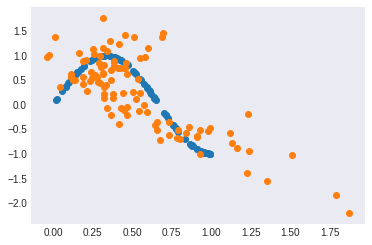

Epoch:999   Acc_real:0.460000   Acc_fake:0.770000


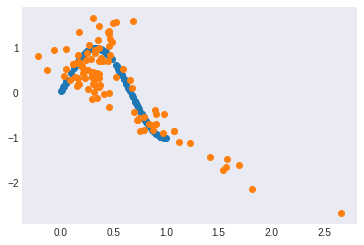

Epoch:1099   Acc_real:0.350000   Acc_fake:0.930000


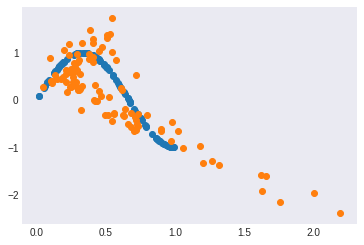

Epoch:1199   Acc_real:0.260000   Acc_fake:0.850000


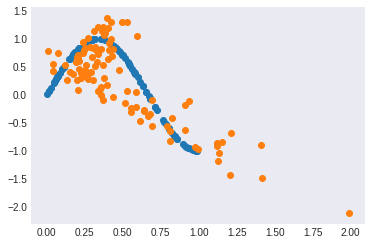

Epoch:1299   Acc_real:0.280000   Acc_fake:0.840000


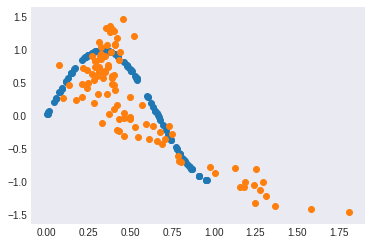

Epoch:1399   Acc_real:0.230000   Acc_fake:0.880000


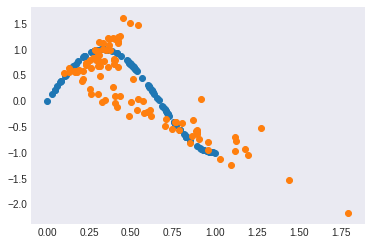

Epoch:1499   Acc_real:0.260000   Acc_fake:0.880000


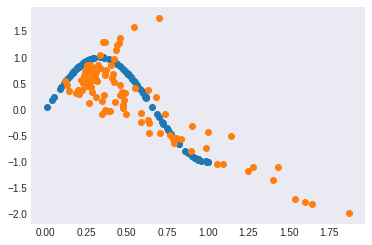

Epoch:1599   Acc_real:0.190000   Acc_fake:0.910000


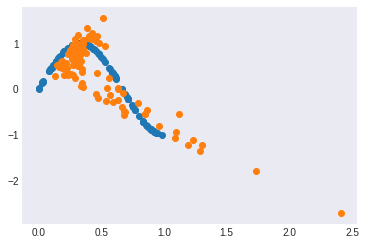

Epoch:1699   Acc_real:0.260000   Acc_fake:0.820000


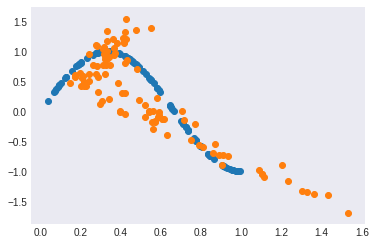

Epoch:1799   Acc_real:0.270000   Acc_fake:0.850000


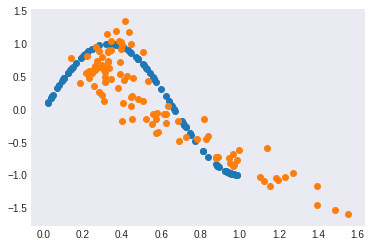

Epoch:1899   Acc_real:0.240000   Acc_fake:0.900000


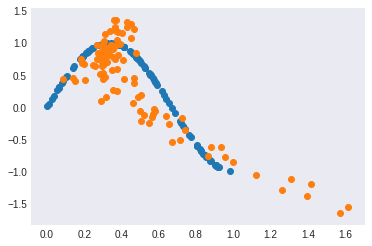

Epoch:1999   Acc_real:0.350000   Acc_fake:0.770000


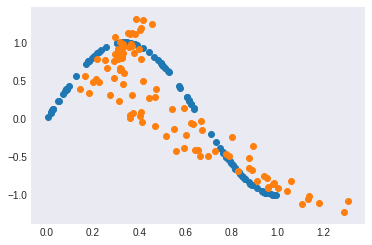

Epoch:2099   Acc_real:0.190000   Acc_fake:0.850000


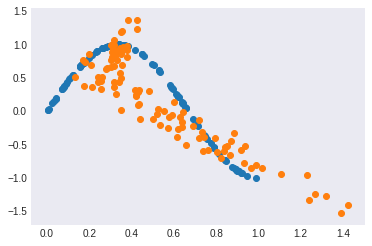

Epoch:2199   Acc_real:0.270000   Acc_fake:0.850000


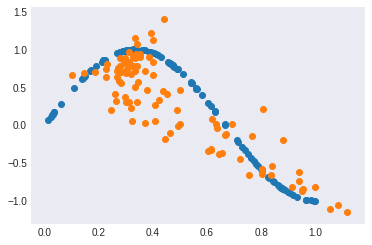

Epoch:2299   Acc_real:0.210000   Acc_fake:0.920000


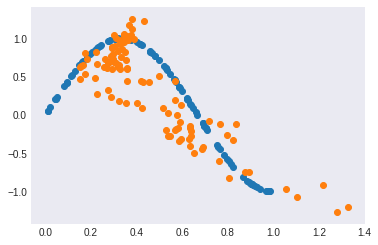

Epoch:2399   Acc_real:0.230000   Acc_fake:0.850000


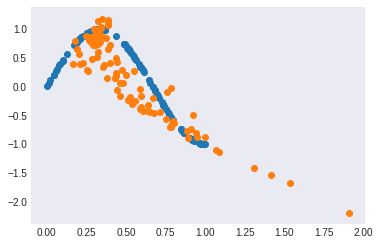

Epoch:2499   Acc_real:0.240000   Acc_fake:0.880000


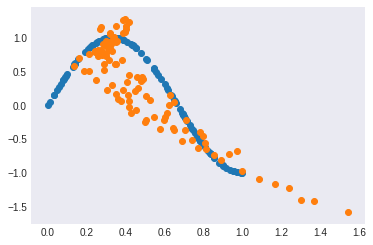

Epoch:2599   Acc_real:0.210000   Acc_fake:0.790000


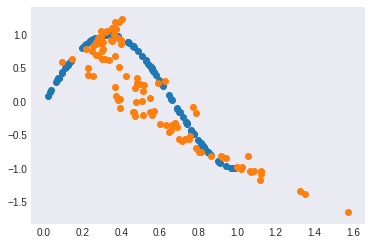

Epoch:2699   Acc_real:0.250000   Acc_fake:0.820000


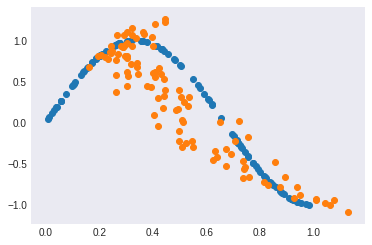

Epoch:2799   Acc_real:0.220000   Acc_fake:0.890000


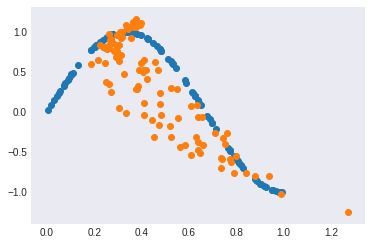

Epoch:2899   Acc_real:0.240000   Acc_fake:0.840000


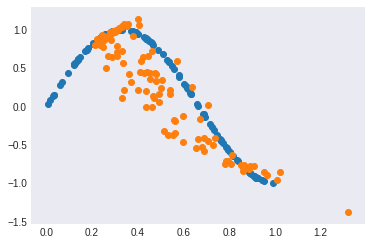

Epoch:2999   Acc_real:0.280000   Acc_fake:0.830000


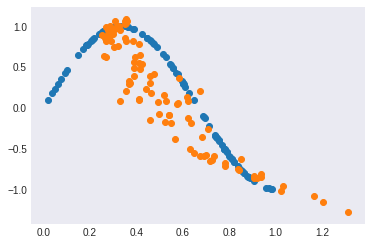

Epoch:3099   Acc_real:0.580000   Acc_fake:0.430000


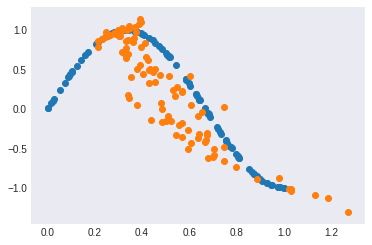

Epoch:3199   Acc_real:0.720000   Acc_fake:0.320000


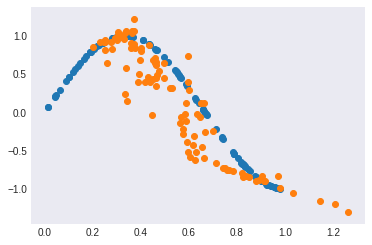

Epoch:3299   Acc_real:0.790000   Acc_fake:0.400000


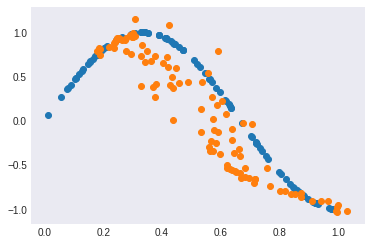

Epoch:3399   Acc_real:0.710000   Acc_fake:0.290000


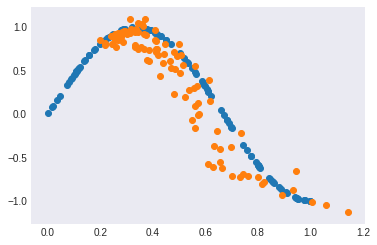

Epoch:3499   Acc_real:0.390000   Acc_fake:0.850000


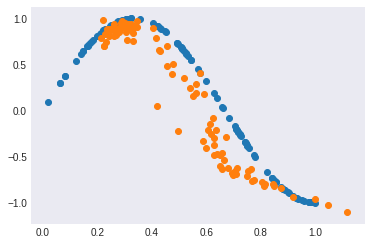

Epoch:3599   Acc_real:0.330000   Acc_fake:0.710000


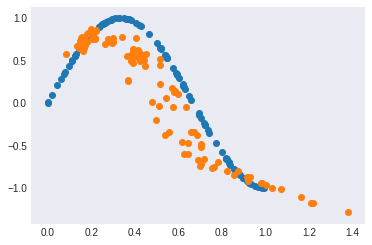

Epoch:3699   Acc_real:0.760000   Acc_fake:0.320000


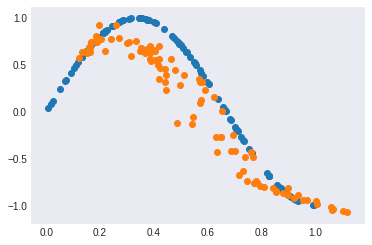

Epoch:3799   Acc_real:0.640000   Acc_fake:0.320000


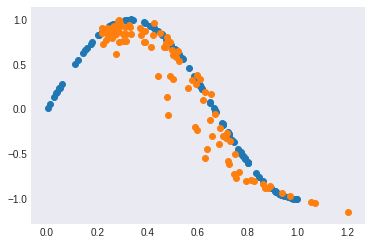

Epoch:3899   Acc_real:0.760000   Acc_fake:0.310000


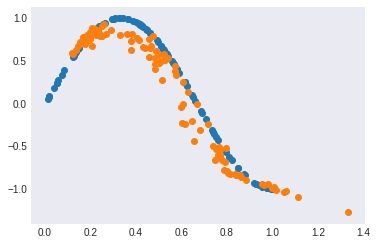

Epoch:3999   Acc_real:0.650000   Acc_fake:0.270000


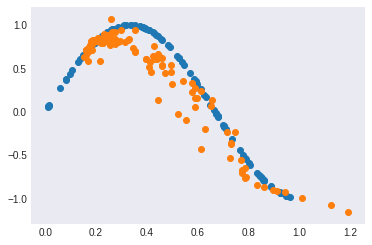

Epoch:4099   Acc_real:0.820000   Acc_fake:0.290000


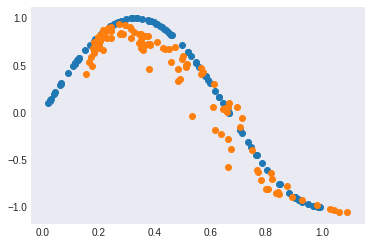

Epoch:4199   Acc_real:0.700000   Acc_fake:0.240000


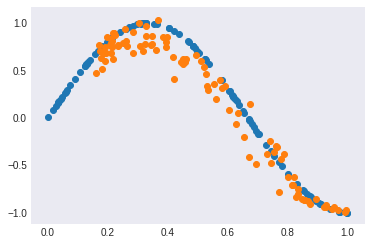

Epoch:4299   Acc_real:0.670000   Acc_fake:0.330000


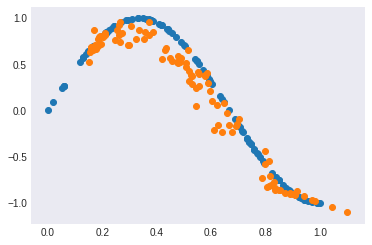

Epoch:4399   Acc_real:0.600000   Acc_fake:0.350000


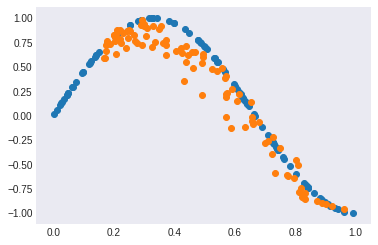

Epoch:4499   Acc_real:0.750000   Acc_fake:0.280000


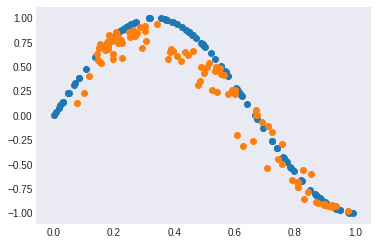

Epoch:4599   Acc_real:0.720000   Acc_fake:0.300000


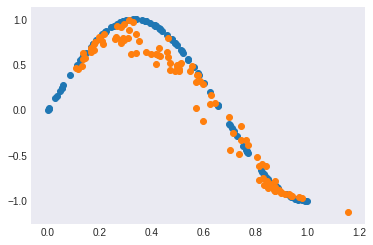

Epoch:4699   Acc_real:0.660000   Acc_fake:0.210000


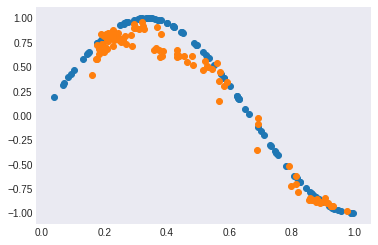

Epoch:4799   Acc_real:0.220000   Acc_fake:0.900000


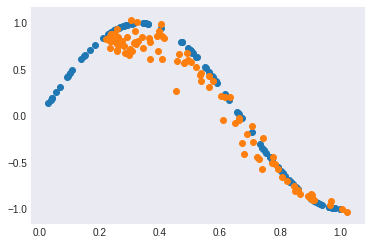

Epoch:4899   Acc_real:0.620000   Acc_fake:0.380000


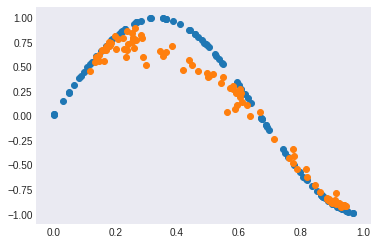

Epoch:4999   Acc_real:0.180000   Acc_fake:0.860000


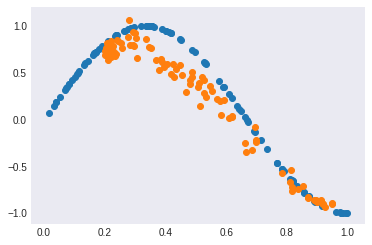

Epoch:5099   Acc_real:0.690000   Acc_fake:0.250000


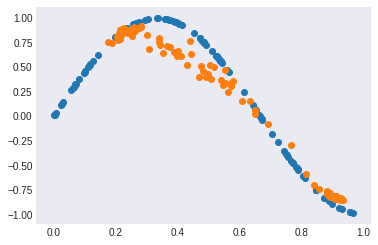

Epoch:5199   Acc_real:0.170000   Acc_fake:0.830000


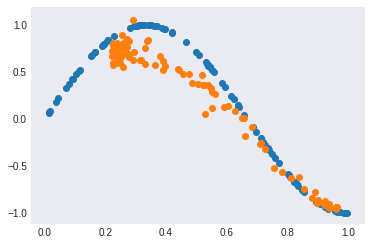

Epoch:5299   Acc_real:0.760000   Acc_fake:0.280000


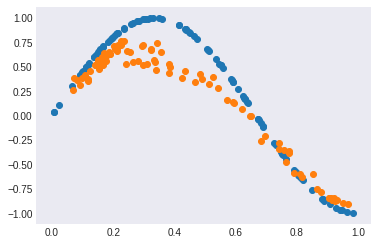

Epoch:5399   Acc_real:0.400000   Acc_fake:0.540000


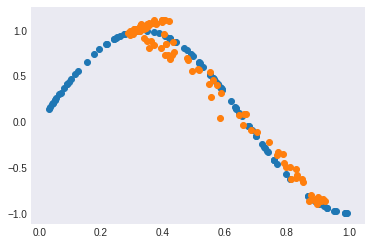

Epoch:5499   Acc_real:0.000000   Acc_fake:1.000000


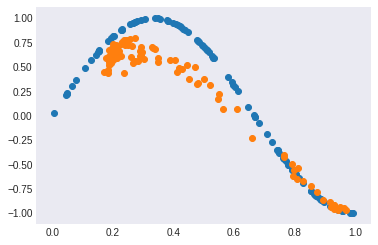

Epoch:5599   Acc_real:0.680000   Acc_fake:0.320000


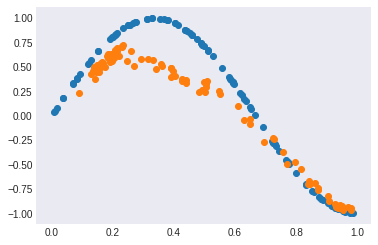

Epoch:5699   Acc_real:0.740000   Acc_fake:0.280000


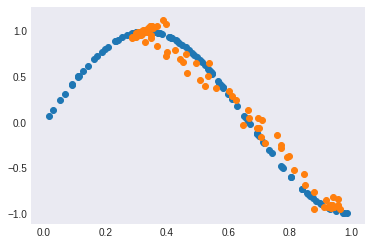

Epoch:5799   Acc_real:0.040000   Acc_fake:0.930000


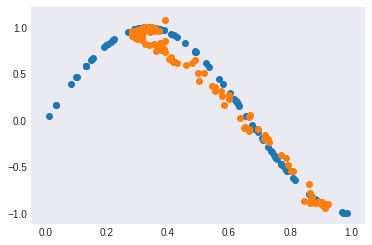

Epoch:5899   Acc_real:0.160000   Acc_fake:0.820000


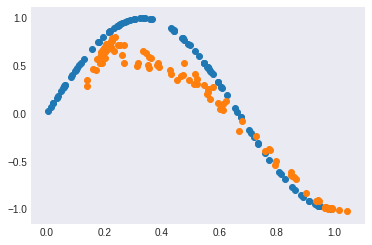

Epoch:5999   Acc_real:0.390000   Acc_fake:0.670000


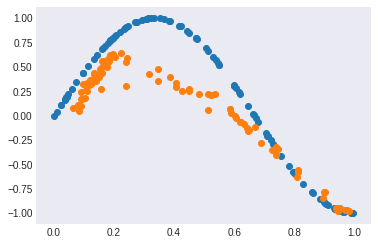

Epoch:6099   Acc_real:0.620000   Acc_fake:0.260000


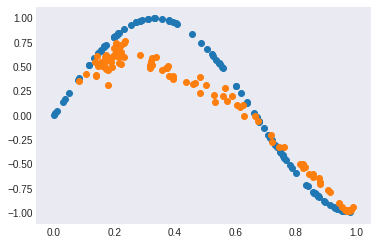

Epoch:6199   Acc_real:0.780000   Acc_fake:0.320000


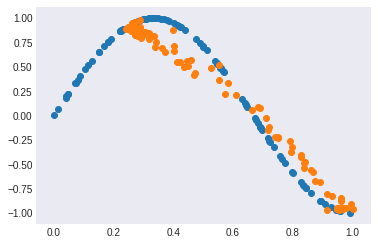

Epoch:6299   Acc_real:0.600000   Acc_fake:0.190000


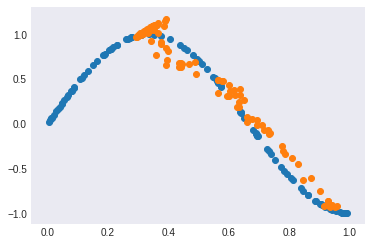

Epoch:6399   Acc_real:0.500000   Acc_fake:0.390000


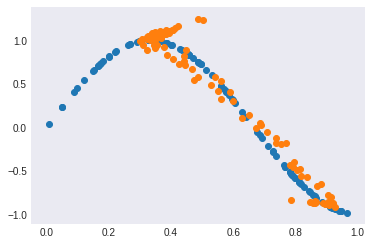

Epoch:6499   Acc_real:0.040000   Acc_fake:0.960000


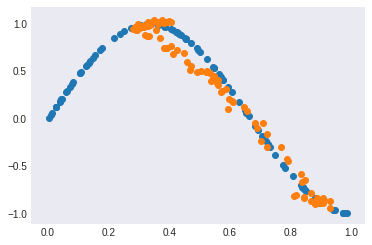

Epoch:6599   Acc_real:0.230000   Acc_fake:0.830000


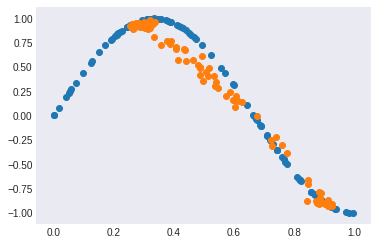

Epoch:6699   Acc_real:0.210000   Acc_fake:0.790000


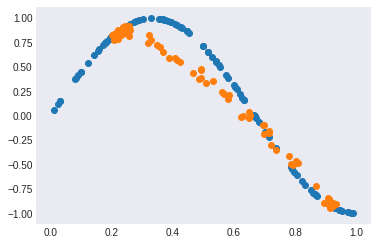

Epoch:6799   Acc_real:0.160000   Acc_fake:0.780000


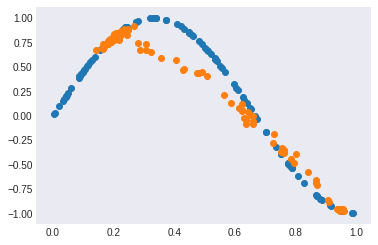

Epoch:6899   Acc_real:0.270000   Acc_fake:0.770000


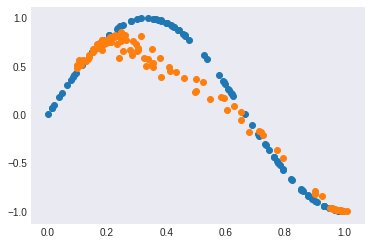

Epoch:6999   Acc_real:0.240000   Acc_fake:0.700000


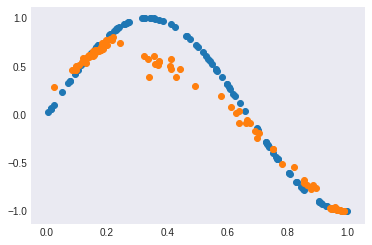

Epoch:7099   Acc_real:0.330000   Acc_fake:0.700000


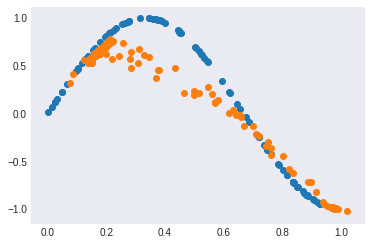

Epoch:7199   Acc_real:0.310000   Acc_fake:0.650000


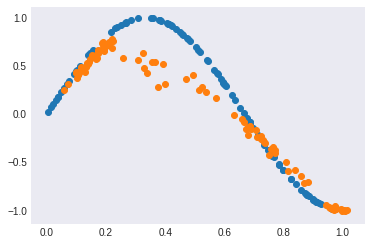

Epoch:7299   Acc_real:0.250000   Acc_fake:0.770000


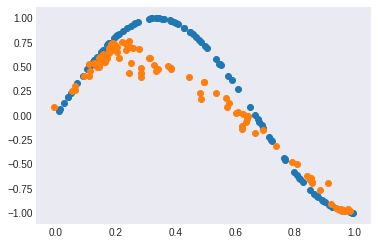

Epoch:7399   Acc_real:0.280000   Acc_fake:0.710000


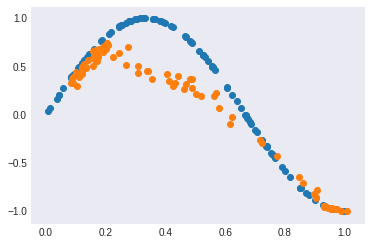

Epoch:7499   Acc_real:0.270000   Acc_fake:0.760000


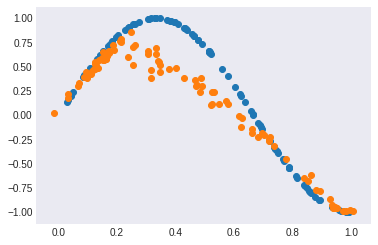

Epoch:7599   Acc_real:0.300000   Acc_fake:0.730000


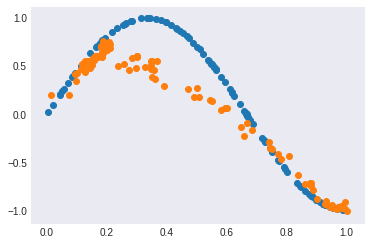

Epoch:7699   Acc_real:0.250000   Acc_fake:0.700000


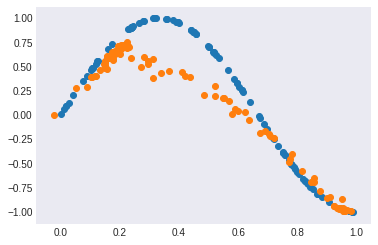

Epoch:7799   Acc_real:0.210000   Acc_fake:0.730000


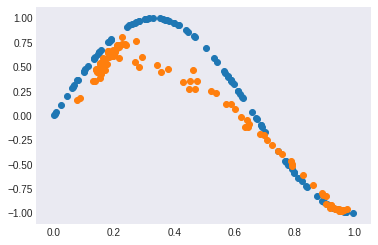

Epoch:7899   Acc_real:0.300000   Acc_fake:0.690000


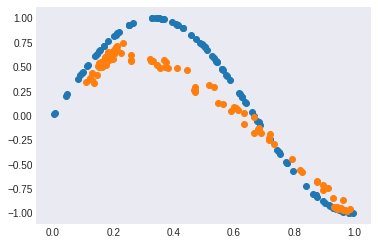

Epoch:7999   Acc_real:0.260000   Acc_fake:0.630000


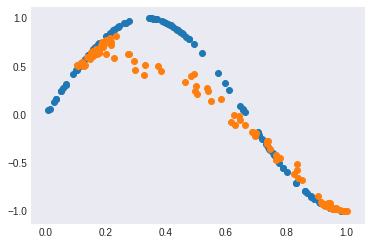

Epoch:8099   Acc_real:0.230000   Acc_fake:0.770000


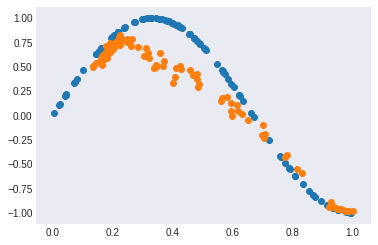

Epoch:8199   Acc_real:0.250000   Acc_fake:0.800000


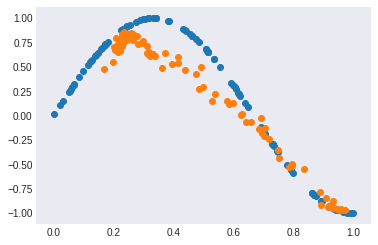

Epoch:8299   Acc_real:0.190000   Acc_fake:0.760000


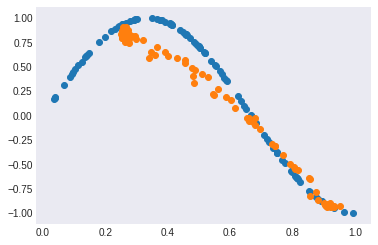

Epoch:8399   Acc_real:0.240000   Acc_fake:0.760000


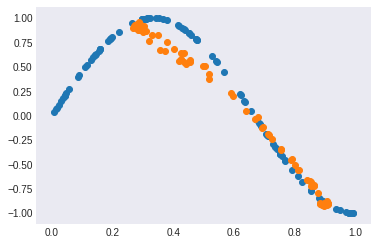

Epoch:8499   Acc_real:0.310000   Acc_fake:0.720000


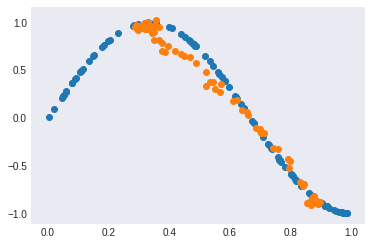

Epoch:8599   Acc_real:0.240000   Acc_fake:0.740000


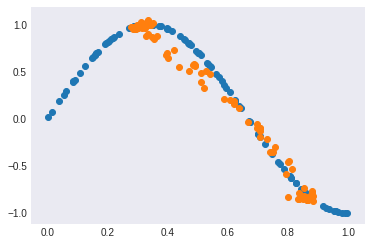

Epoch:8699   Acc_real:0.030000   Acc_fake:0.950000


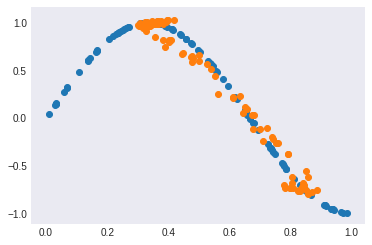

Epoch:8799   Acc_real:0.400000   Acc_fake:0.430000


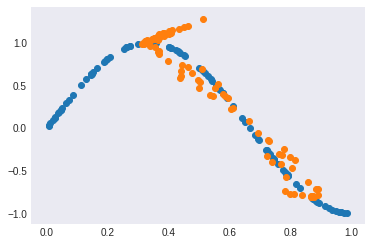

Epoch:8899   Acc_real:0.640000   Acc_fake:0.270000


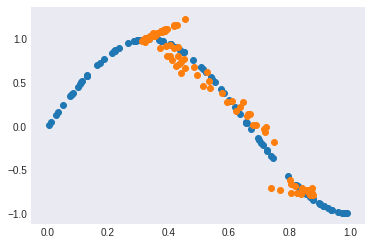

Epoch:8999   Acc_real:0.730000   Acc_fake:0.270000


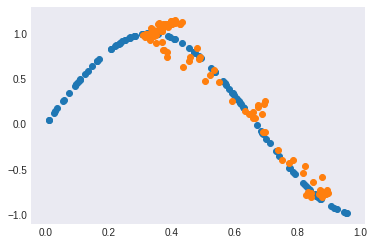

Epoch:9099   Acc_real:0.750000   Acc_fake:0.210000


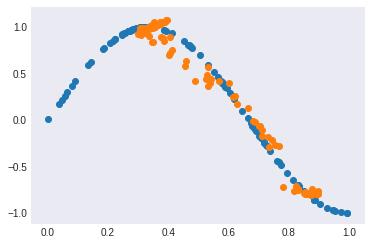

Epoch:9199   Acc_real:0.730000   Acc_fake:0.290000


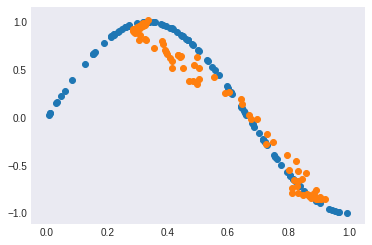

Epoch:9299   Acc_real:0.720000   Acc_fake:0.220000


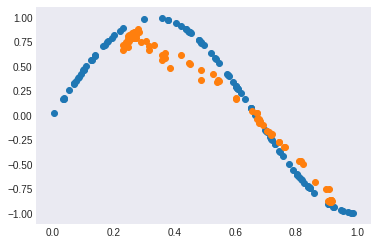

Epoch:9399   Acc_real:0.700000   Acc_fake:0.220000


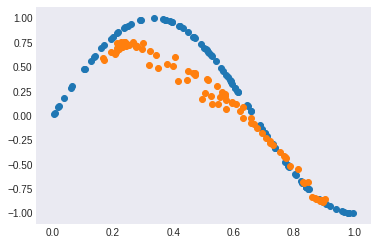

Epoch:9499   Acc_real:0.680000   Acc_fake:0.230000


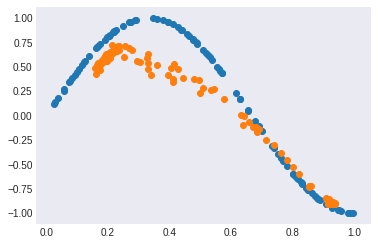

Epoch:9599   Acc_real:0.920000   Acc_fake:0.080000


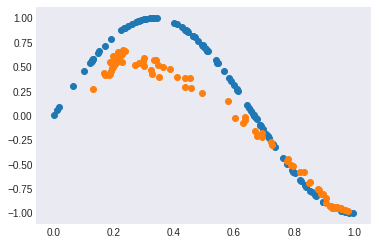

Epoch:9699   Acc_real:0.780000   Acc_fake:0.240000


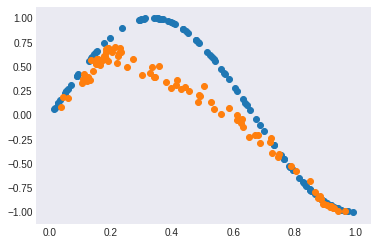

Epoch:9799   Acc_real:0.180000   Acc_fake:0.760000


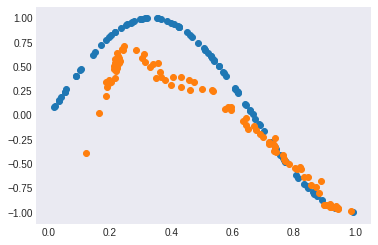

Epoch:9899   Acc_real:0.330000   Acc_fake:0.630000


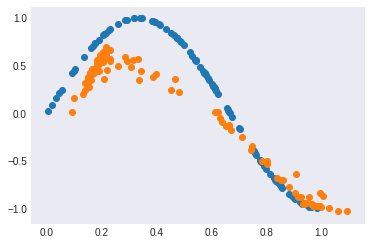

Epoch:9999   Acc_real:0.270000   Acc_fake:0.780000


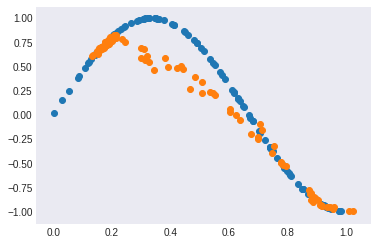

CPU times: user 10min 1s, sys: 46.2 s, total: 10min 47s
Wall time: 8min 53s


In [0]:
# n_batch을 1024로 늘려서 해봄!
%%time
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

# train model: override=True -> 같은 위치에 plot
train(generator, discriminator, gan_model, latent_dim, n_batch=1024) # 파라미터로 n_epochs는 default가 10000이므로, 10000번 전체 훈련을 함!


### 과제2

- #### 결과를 분석해 보자